# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3 as sq
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import MaxAbsScaler,StandardScaler
from tqdm import tqdm
import os
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from wordcloud import WordCloud,STOPWORDS
from prettytable import PrettyTable
import seaborn as sn
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import FeatureUnion

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [34]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [35]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [36]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [37]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [38]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [39]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [40]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [41]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [42]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [43]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [44]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [45]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [46]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [47]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [48]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [49]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [50]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [51]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [52]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [53]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [54]:
# Combining all the above pre - processing steps 
from tqdm import tqdm
preprocessed_reviews = []
snowBall = SnowballStemmer('english')
# tqdm is for printing the status bar
for sentence in tqdm(final['Text'].values,position= 0,mininterval= 1):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    sentence = ' '.join(snowBall.stem(words) for words in sentence.split())
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [06:02<00:00, 1005.38it/s]


In [55]:
preprocessed_reviews[2500]

'salt free season blend great product sanction salt consumpt great flavor much less expens via amazon com store purchas find'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [56]:
## Performing Preprocessing for Summary review.
preprocessed_summary = []
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
for summ_sentence in tqdm(final['Summary'].values):
    summ_sentence = re.sub(r"http\S+","",summ_sentence)
    summ_sentence = BeautifulSoup(summ_sentence, 'lxml').get_text()
    summ_sentence = decontracted(summ_sentence)
    summ_sentence = re.sub("\S*\d\S*", "",summ_sentence)
    summ_sentence = re.sub('[^A-Za-z]+',' ',summ_sentence)
    summ_sentence = ' '.join(snowBall.stem(words) for words in summ_sentence.split())
    summ_sentence = ' '.join(e.lower() for e in summ_sentence.split() if e.lower() not in stopwords)
    preprocessed_summary.append(summ_sentence.strip())


100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [01:32<00:00, 3951.64it/s]


In [57]:
preprocessed_summary[2500] # preprocessed summary review

'product qualiti'

In [60]:
#Storing the review text and summary with preprocessed values
final['Text'] = preprocessed_reviews
final['Summary'] = preprocessed_summary

#Storing the preprocessed dataframe on HDD
conn = sq.connect('AmazonReviewFiltered.sqlite')
final.to_sql('Reviews', conn,if_exists= 'replace' )

conn = sq.connect('AmazonReviewFiltered.sqlite')
AmazonReviewDataFiltered = pd.read_sql_query("""SELECT * FROM Reviews """, conn)

AmazonReviewDataFiltered.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,everi book educ,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,love book miss hard cover version,grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup rice month,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,good swingi rhythm read aloud,great littl book read aloud nice rhythm well g...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,great way learn month,book poetri month year goe month cute littl po...


In [61]:
AmazonReviewDataFiltered['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [62]:
# Sampling 100k data points from AmazonREviewDataFiltered to perform BoW, TF - IDF, word2vec and TF - IDF avgerage w2v, to reduce processing time.
AmazonPositiveReviewData = AmazonReviewDataFiltered[AmazonReviewDataFiltered['Score'] == 1].sample(n =84300) # Sampling 84300 positive data points from AmazonReviewDataFiltered, i.e. 84.3%
AmazonNegativeReviewData = AmazonReviewDataFiltered[AmazonReviewDataFiltered['Score'] == 0].sample(n = 15700) # Sampling 15700 negative data points from AmazonReviewDataFiltered, i.e. 15.7%
AmazonReviewDataSampled = AmazonPositiveReviewData.append(AmazonNegativeReviewData, ignore_index= True) # Appending the samples of positive and negative data points to form AmazonReviewDataSampled 
AmazonReviewDataSampled.head(4)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,154224,167221,B0001FR0BG,A1VZORXF077BQW,"A. Pagnotta ""blow up your tv""",3,3,1,1299715200,love soda,not drink soda somehow got sucker tri serious ...
1,41774,45386,B0011MTYF8,A2RJ86TWE0DEQV,J. Curley,15,15,1,1242259200,great varieti high qualiti,shave ice syrup not dissapoint bought less exp...
2,420059,454255,B002GWMCCE,A1YUHHL5KI87J1,"Alexis,momto8",0,0,1,1325721600,excel decaff,sam club discontinu decaff thought end world f...
3,55313,60015,B0016861WQ,A1ODOGXEYECQQ8,Nuknuk,0,0,1,1256774400,great tast gummi bear,like much favorit haribo like later black fore...


In [63]:
AmazonReviewDataSampled.tail(4)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
99996,114390,124070,B000IYYRXO,A2FJOJFKYCNX9V,Linda3777,0,0,0,1291680000,bitter,purchas spite prior custom review said drink n...
99997,343917,372049,B000SATIFA,A2CXROF75RTCXB,N. Conrad,0,0,0,1351123200,flavorless green tea,vacuum pack bag great tea blah hint tea flavor...
99998,291077,315328,B0050TDLUW,A3LHLGOI96VUSQ,Huntergirl,0,0,0,1347926400,hard,bought mistak normal get strip dog seller love...
99999,199772,216504,B0039556K2,AG2S7N7ZPPNW2,jeciwall28,0,0,0,1325116800,not,love thing raspberri chocol not not like stron...


In [64]:
AmazonReviewDataSampled['Score'].value_counts()

1    84300
0    15700
Name: Score, dtype: int64

In [65]:
conn = sq.connect('AmazonReviewDataSampled.sqlite')
AmazonReviewDataSampled.to_sql('Reviews', conn,if_exists= 'replace' )

In [2]:
con = sq.connect('AmazonReviewDataSampled.sqlite')
AmazonReviewDataSampled = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)

In [3]:
AmazonReviewDataSampled['Score'].value_counts()

1    84300
0    15700
Name: Score, dtype: int64

In [4]:
# Program to split and sort the positive and negative reviews of the amazon dataset based on time.
AmazonReviewDataSampledPositive = AmazonReviewDataSampled[AmazonReviewDataSampled['Score'] == 1]

AmazonReviewDataSampledNegative = AmazonReviewDataSampled[AmazonReviewDataSampled['Score'] == 0]
# Program to sort the positive and negative review dataset with respect to time.
AmazonReviewDataSampledPositive.sort_values(by = ['Time'],axis = 0,ascending= True, inplace= True )
AmazonReviewDataSampledNegative.sort_values(by = ['Time'],axis = 0,ascending= True, inplace= True)

In [5]:
AmazonReviewDataSampledPositive.head(4)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
79819,79819,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,everi book educ,witti littl book make son laugh loud recit car...
24973,24973,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,whole seri great way spend time child,rememb see show air televis year ago child sis...
45079,45079,70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,sure death fli,bought apart infest fruit fli onli hour trap a...
39018,39018,138001,149770,B00004S1C5,A1KXONFPU2XQ5K,Stephanie Manley,8,8,1,965779200,veri easi use,much easier use wilson past color color vibran...


In [6]:
AmazonReviewDataSampledNegative.head(4)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
86871,86871,417901,451923,B00004CXX9,ANIMV3SPDD8SH,Guy De Federicis,1,12,0,992217600,casper ghost,michael keaton bring no distinguish characteri...
86512,86512,346040,374342,B00004CI84,A10L8O1ZMUIMR2,G. Kleinschmidt,61,79,0,1040947200,great movi turn bad,let know movi one person favorit ghost movi sa...
99140,99140,195834,212291,B0000DGFAC,A18OE4IVSZMZ8E,"Sheri Johnson ""sherilees""",31,34,0,1075420800,would bought seen,plant veri healthi arriv quick good shape disa...
93383,93383,316306,342462,B000084F3O,A3DWUM6SN3N3NR,"Author Brian Wallace (Mind Transmission, Inc.)",4,33,0,1076457600,unnatur odor,realli hate fan van patten year feel must save...


In [7]:
# Performing Time Based Spliting of the positive and negative reviews to form 70% of train and 30% of test dataset.
Positive_tr = AmazonReviewDataSampledPositive[0:59010]

Positive_ts = AmazonReviewDataSampledPositive[59010:]

Negative_tr = AmazonReviewDataSampledNegative[0:10990]
Negative_ts = AmazonReviewDataSampledNegative[10990:]

AmazonReviewDataSampledTrain = Positive_tr.append(Negative_tr, ignore_index = True)
AmazonReviewDataSampledTest = Positive_ts.append(Negative_ts, ignore_index = True)

In [8]:
AmazonReviewDataSampledTrain.head(4)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,79819,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,everi book educ,witti littl book make son laugh loud recit car...
1,24973,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,whole seri great way spend time child,rememb see show air televis year ago child sis...
2,45079,70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,sure death fli,bought apart infest fruit fli onli hour trap a...
3,39018,138001,149770,B00004S1C5,A1KXONFPU2XQ5K,Stephanie Manley,8,8,1,965779200,veri easi use,much easier use wilson past color color vibran...


In [9]:
AmazonReviewDataSampledTest.head(4)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,20291,390027,421711,B002VLZ8D0,A116877Q0NXXWL,Katie Wagg,0,0,1,1328659200,love,mother law got hook coconut oil christma use e...
1,33622,327637,354619,B000LKU3A6,A25T49CJ2PAEZH,Captain Action,0,0,1,1328659200,spirit jerki product,packag arriv prompt content excel condit produ...
2,28188,261626,283607,B001EO65KA,A3BQUF3URM6065,"Suzie Wood ""sjw""",0,0,1,1328659200,k cup,select coffe varieti pack meet daili need good...
3,81115,255782,277301,B000VK8AVK,A1JFGBFN1W5G6U,Daniel L. Bateman,0,0,1,1328659200,delici not bad,not like sweet potato like sweet potato fri lo...


In [10]:
AmazonReviewDataSampledTrain['Score'].value_counts()

1    59010
0    10990
Name: Score, dtype: int64

In [11]:
AmazonReviewDataSampledTest['Score'].value_counts()

1    25290
0     4710
Name: Score, dtype: int64

In [12]:
AmazonReviewDataSampledTrain_RBF = AmazonReviewDataSampledTrain.sample(40000,random_state= 6)
AmazonReviewDataSampledTrain_RBF.shape

(40000, 12)

# [4] Featurization

## [4.1] BAG OF WORDS

In [13]:
#BoW
#Performing Bag of words vectorizer using sklearn inbuit function countvectorizer for train and test data for review text
bagofwords = CountVectorizer() #in scikit-learn
bagofwords.fit(AmazonReviewDataSampledTrain['Text'])
print("some feature names ", bagofwords.get_feature_names()[:10])
print('='*117)


bowTrain = bagofwords.transform(AmazonReviewDataSampledTrain['Text'])
print("the type of count vectorizer ",type(bowTrain))
print("the shape of our text BOW Train vectorizer ",bowTrain.get_shape())
print("the number of unique words ", bowTrain.get_shape()[1])
print("*"*117)

bowTest = bagofwords.transform(AmazonReviewDataSampledTest['Text'])
print("The shape of our text BOW Test vectorizer:" , bowTest.get_shape())


some feature names  ['aa', 'aaa', 'aaaa', 'aaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaagghh', 'aaaaaaahhhhhh']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of our text BOW Train vectorizer  (70000, 35222)
the number of unique words  35222
*********************************************************************************************************************
The shape of our text BOW Test vectorizer: (30000, 35222)


In [14]:
#Standardizing the bag of word vectorizer using Max Absolute scaler since bag of words vectorizer is a CSR matrix
maxscaler = MaxAbsScaler()
bowTrain = maxscaler.fit_transform(bowTrain)
bowTest = maxscaler.transform(bowTest)

In [15]:
#BoW
#Performing bag of words vectorizer using countvectorizer for train and test data for summary review
bagofwordsSum = CountVectorizer() #in scikit-learn
bagofwordsSum.fit(AmazonReviewDataSampledTrain['Summary'])
print("some feature names ", bagofwordsSum.get_feature_names()[:10])
print('='*117)

bowTrainSum = bagofwordsSum.transform(AmazonReviewDataSampledTrain['Summary'])
print("the type of count vectorizer ",type(bowTrainSum))
print("the shape of our text BOW Train vectorizer ",bowTrainSum.get_shape())
print("the number of unique words ", bowTrainSum.get_shape()[1])
print("*"*117)

bowTestSum = bagofwordsSum.transform(AmazonReviewDataSampledTest['Summary'])
print("The shape of our text BOW Test vectorizer:" , bowTestSum.get_shape())


some feature names  ['aaa', 'aaaa', 'aaaahhhh', 'aahh', 'aamz', 'aardvark', 'ab', 'abb', 'abba', 'abc']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of our text BOW Train vectorizer  (70000, 10432)
the number of unique words  10432
*********************************************************************************************************************
The shape of our text BOW Test vectorizer: (30000, 10432)


In [16]:
#Column standardization
maxscaler = MaxAbsScaler()
bowTrainSum = maxscaler.fit_transform(bowTrainSum)
bowTestSum = maxscaler.transform(bowTestSum)

## [4.2] Bi-Grams and n-Grams.

In [17]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numbers min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(AmazonReviewDataSampledTrain['Text'])
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (70000, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [18]:
#Performing TFIDF vectorizer for train and test data using text review
tfidfVec = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tfidfVec.fit(AmazonReviewDataSampledTrain['Text'])
print("some sample features(unique words in the corpus)",tfidfVec.get_feature_names()[0:10])
print('='*117)

tfidfTrain = tfidfVec.transform(AmazonReviewDataSampledTrain['Text'])
print("the type of count vectorizer ",type(tfidfTrain))
print("the shape of out text TFIDF Train vectorizer ",tfidfTrain.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidfTrain.get_shape()[1])
print('*'*117)
tfidfTest = tfidfVec.transform(AmazonReviewDataSampledTest['Text'])
print("the shape of out text TFIDF Test vectorizer ",tfidfTest.get_shape())
print('='*117)

some sample features(unique words in the corpus) ['aback', 'abandon', 'abdomin', 'abil', 'abl', 'abl buy', 'abl chew', 'abl drink', 'abl eat', 'abl enjoy']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF Train vectorizer  (70000, 43669)
the number of unique words including both unigrams and bigrams  43669
*********************************************************************************************************************
the shape of out text TFIDF Test vectorizer  (30000, 43669)


In [19]:
#Column standardization
maxscaler = MaxAbsScaler()
tfidfTrain = maxscaler.fit_transform(tfidfTrain)
tfidfTest = maxscaler.transform(tfidfTest)

In [20]:
#TFIDF vectorizer for train and test data for summary review
tfidfVecSum = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tfidfVecSum.fit(AmazonReviewDataSampledTrain['Summary'])
print("some sample features(unique words in the corpus)",tfidfVecSum.get_feature_names()[0:10])
print('='*117)

tfidfTrainSum = tfidfVecSum.transform(AmazonReviewDataSampledTrain['Summary'])
print("the type of count vectorizer ",type(tfidfTrainSum))
print("the shape of out text TFIDF Train vectorizer ",tfidfTrainSum.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidfTrainSum.get_shape()[1])
print('*'*117)
tfidfTestSum = tfidfVecSum.transform(AmazonReviewDataSampledTest['Summary'])
print("the shape of out text TFIDF Test vectorizer ",tfidfTestSum.get_shape())
print('='*117)

some sample features(unique words in the corpus) ['abl', 'abov', 'absolut', 'absolut amaz', 'absolut best', 'absolut delici', 'absolut favorit', 'absolut love', 'absolut wonder', 'acai']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF Train vectorizer  (70000, 3326)
the number of unique words including both unigrams and bigrams  3326
*********************************************************************************************************************
the shape of out text TFIDF Test vectorizer  (30000, 3326)


In [21]:
#Column standardization
maxscaler = MaxAbsScaler()
tfidfTrainSum = maxscaler.fit_transform(tfidfTrainSum)
tfidfTestSum = maxscaler.transform(tfidfTestSum)

## [4.4] Word2Vec

In [22]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in AmazonReviewDataSampledTrain['Text']:
    list_of_sentance.append(sentance.split())

In [23]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*117)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantast', 0.8354769349098206), ('terrif', 0.7976232171058655), ('excel', 0.7949914932250977), ('good', 0.7735630869865417), ('awesom', 0.7514445781707764), ('perfect', 0.7069741487503052), ('wonder', 0.7055458426475525), ('nice', 0.6661141514778137), ('fabul', 0.6424923539161682), ('decent', 0.6411577463150024)]
[('best', 0.8277009725570679), ('greatest', 0.8061903715133667), ('tastiest', 0.7338059544563293), ('nastiest', 0.6873146295547485), ('closest', 0.6545197367668152), ('nicest', 0.6247959733009338), ('saltiest', 0.6066642999649048), ('freshest', 0.6015564203262329), ('superior', 0.5865951776504517), ('disgust', 0.5741315484046936)]


In [24]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  11038
sample words  ['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'learn', 'whale', 'india', 'droop', 'rose', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'song', 'student', 'teach', 'preschool', 'turn']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v for Text review

In [25]:
# average Word2Vec
# compute average word2vec for each review.
avgW2VTrain = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(AmazonReviewDataSampledTrain['Text'].values): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgW2VTrain.append(sent_vec)
#print(len(avgW2VTrain))
print('The shape of avgerage word to vector for Train data  is ','(',len(avgW2VTrain),',',len(avgW2VTrain[0]),')')
#column standzrdization
scale = StandardScaler()
avgW2VTrain = scale.fit_transform(avgW2VTrain)

100%|██████████████████████████████████████████████████████████████████████████| 70000/70000 [01:03<00:00, 1097.51it/s]


The shape of avgerage word to vector for Train data  is  ( 70000 , 50 )


In [26]:
# average Word2Vec
# compute average word2vec for each review.
avgW2VTest = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(AmazonReviewDataSampledTest['Text'].values): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgW2VTest.append(sent_vec)
print('The shape of avgerage word to vector for Test data  is ','(',len(avgW2VTest),',',len(avgW2VTest[0]),')')
avgW2VTest = scale.transform(avgW2VTest)# column standardization

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:27<00:00, 1100.93it/s]


The shape of avgerage word to vector for Test data  is  ( 30000 , 50 )


<b> AVG W2V for Summary

In [27]:
# average Word2Vec
# compute average word2vec for each review.
avgW2VTrainSum = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(AmazonReviewDataSampledTrain['Summary'].values): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgW2VTrainSum.append(sent_vec)
#print(len(avgW2VTrain))
print('The shape of avgerage word to vector for Train data  is ','(',len(avgW2VTrainSum),',',len(avgW2VTrainSum[0]),')')
#column standardization
scale = StandardScaler()
avgW2VTrainSum = scale.fit_transform(avgW2VTrainSum)

100%|█████████████████████████████████████████████████████████████████████████| 70000/70000 [00:05<00:00, 13221.90it/s]


The shape of avgerage word to vector for Train data  is  ( 70000 , 50 )


In [28]:
# average Word2Vec
# compute average word2vec for each review.
avgW2VTestSum = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(AmazonReviewDataSampledTest['Summary'].values): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgW2VTestSum.append(sent_vec)
print('The shape of avgerage word to vector for Test data  is ','(',len(avgW2VTestSum),',',len(avgW2VTestSum[0]),')')
avgW2VTestSum = scale.transform(avgW2VTestSum)# column standardization

100%|█████████████████████████████████████████████████████████████████████████| 30000/30000 [00:02<00:00, 12936.31it/s]


The shape of avgerage word to vector for Test data  is  ( 30000 , 50 )


#### [4.4.1.2] TFIDF weighted W2v for text review


In [29]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(AmazonReviewDataSampledTrain['Text'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [30]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidfw2vTrain = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(AmazonReviewDataSampledTrain['Text'], mininterval= 1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfw2vTrain.append(sent_vec)
    row += 1



100%|████████████████████████████████████████████████████████████████████████████| 70000/70000 [13:03<00:00, 89.29it/s]


In [31]:

tfidfw2vTest = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(AmazonReviewDataSampledTest['Text'], mininterval= 1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfw2vTest.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [04:48<00:00, 103.95it/s]


In [32]:
#column standardization
scale = StandardScaler()
tfidfw2vTrain = scale.fit_transform(tfidfw2vTrain)
tfidfw2vTest = scale.transform(tfidfw2vTest)

### TFIDFAVGW2V for summary review

In [33]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrixSum = model.fit_transform(AmazonReviewDataSampledTrain['Summary'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidfw2vTrainSum = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(AmazonReviewDataSampledTrain['Summary'], mininterval= 1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfw2vTrainSum.append(sent_vec)
    row += 1



100%|██████████████████████████████████████████████████████████████████████████| 70000/70000 [00:18<00:00, 3780.01it/s]


In [34]:

tfidfw2vTestSum = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(AmazonReviewDataSampledTest['Summary'], mininterval= 1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfw2vTestSum.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:07<00:00, 3774.56it/s]


In [35]:
#Column standardization
scale = StandardScaler()
tfidfw2vTrainSum = scale.fit_transform(tfidfw2vTrainSum)
tfidfw2vTestSum = scale.transform(tfidfw2vTestSum)

In [39]:
def clf(x_train,y_train,model):
    """Function to determine the optimal depth and minimum samples split for decision tree classifier
    Parameters:
    x_train : array-like or sparse matrix of shape = [n_samples, n_features], the training input samples
    y_train : actual output
     
    
    returns the optimal hyperparameter for the Random Forest and XGboost classifier.
    
    """
    depth = [1,5,10,50,100,500] # list for hyperparameter tunning 
    estimators = [5,10,100] # list for hyperparameter tunning
    cv_scores = np.zeros((len(depth),len(estimators))) # list to store the cv scores
    trainscores = np.zeros((len(depth),len(estimators)))# list to store the train scores
    
   # Hyperparameter tunning for Random Forest and Xgboost.
    for x in range(len(depth)):
        print('='*117)
        print("For depth = %r"%depth[x])
        for y in range(len(estimators)):
            #Initializing the Random Forest classifier
            if model == 'Random Forest':
                classifier = RandomForestClassifier(n_estimators= estimators[y],max_depth= depth[x],class_weight="balanced",n_jobs= -1)
            
            else:
                #Initializing the XGboost classifier
                classifier = XGBClassifier(max_depth= depth[x],n_estimators=estimators[y],learning_rate= 0.001,scale_pos_weight= 0.186,n_jobs= -1)
            
            #Performing calibration of the classifier
            classifier.fit(x_train,y_train)
            classifier_calib = CalibratedClassifierCV(base_estimator= classifier,method = 'sigmoid')
            classifier_calib.fit(x_train,y_train)
            #CV score and train error using cross_validate function
            score = cross_validate(estimator= classifier_calib,X=x_train,y=y_train,n_jobs= -1,cv= 10,scoring='roc_auc',return_train_score= True)
            cv_scores[x][y] = score['test_score'].mean() # mean value of cv score
            trainscores[x][y] = score['train_score'].mean() # mean value of train error
            print('Number of Estimators = %r , the auc for train data = %r and cv data = %r'%(estimators[y],np.round(trainscores[x][y],5),np.round(cv_scores[x][y],5)))
    print('='*117)
    
    #To plot auc of CV and Train data for different values of hyperparameter using heat map.
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    sn.heatmap(cv_scores,annot=True,fmt=".3f",yticklabels= depth,xticklabels=estimators)# heat map for cv score
    plt.ylabel('depth of tree')
    plt.xlabel('estimators')
    plt.title('Heatmap of AUC for CV data')
    plt.subplot(1,3,3)
    sn.heatmap(trainscores,annot=True,fmt=".3f",yticklabels= depth,xticklabels=estimators) # heat map for train score
    plt.ylabel('depth of tree')
    plt.xlabel('estimators')
    plt.title('Heatmap of AUC for Train data')
    a,b = np.where(cv_scores == cv_scores.max()) # max value of auc for cv.
    
    
    return depth[a[0]],estimators[b[0]] # returning the optimal depth and minimum samples split for Decision tree classifier
    
    
                             
def clfperformance(x_train,y_train,x_test,y_test,estimator,depth,classifier):
    """Classifier performance for Random Forest and Xgboost.
    Parameters:
    x_train  : array-like or sparse matrix of shape = [n_samples, n_features], the training input samples
    y_train : actual output of x_train
    x_test : array-like or sparse matrix of shape = [n_samples, n_features]. the test data.
    y_test : actual output of x_test
    estimator : number of estimators for ensemble models
    optimal_depth : depth for Random forest and Xgboost
    classifier : Random forest or Xgboost

    
    """
    if classifier == 'Random Forest':
        # initializing random forest classifier
        model = RandomForestClassifier(n_estimators= estimator,max_depth= depth,class_weight="balanced",n_jobs= -1)
    
    else :
        # initializing Xgboost classifier
        model = XGBClassifier(max_depth= depth,n_estimators=estimator,learning_rate= 0.001,scale_pos_weight= 0.186,n_jobs= -1)
    
    model = model.fit(x_train,y_train)
    # Model calibration
    model_calib = CalibratedClassifierCV(base_estimator=model,method='sigmoid')
    model_calib.fit(x_train,y_train)
    predict = model_calib.predict(x_test) # predict the output
    auc_test = roc_auc_score(y_test,predict) # auc for test data
    auc_train = roc_auc_score(y_train,model_calib.predict(x_train))# auc for train data
    print('AUC for Train data is  ',auc_train,'\n')
    print('AUC for the Test data is  ', auc_test,'\n')
    confusionMatrix = confusion_matrix(y_test,predict) # confusion matrix
    TPR = (confusionMatrix[1,1] / (confusionMatrix[1,0] + confusionMatrix[1,1])) * 100 # calculating the TPR 
    TNR = (confusionMatrix[0,0] / (confusionMatrix[0,0] + confusionMatrix[0,1])) * 100 # calculating the TNR
    fprTest,tprTest,thresholdTest = roc_curve(y_test,predict) # roc curve for test data
    fprTrain,tprTrain,thresholdTrain = roc_curve(y_train,model_calib.predict(x_train))# roc curve for train data
    # Plot of roc curve for test and train data
    plt.figure(figsize=(20,10))
    plt.plot(fprTest,tprTest,label = 'roc of Test data')
    plt.plot(fprTrain,tprTrain,label = 'roc of Train data')
    plt.legend()
    plt.title('Plot of ROC curve for Test and Train data')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    # plot of confusion matrix using heat map
    plt.figure(figsize=(20,10))
    sn.heatmap(confusionMatrix,annot=True,fmt="d")
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title('Heatmap of Confusion matrix')
    print('True positive rate =',TPR)
    print('True negative rate =',TNR)
    
    
    return auc_test,auc_train,TPR,TNR,model.feature_importances_ 
    
def TopFeatures(numoffeat, vectorizer, coef):
    """Function to print top features in positive and negative class using word cloud
    
    numoffeat = number of features to print 
    vectorizer = bag of words or TFIDF
    coef: coeficeints of Decision Tree classifier
    
    
    
    """
    # obtaining feature names from vectorizer
    if vectorizer == combined_features:
        feature_names =[]
        for x in vectorizer.get_feature_names():
            feature_names.append(x[11:] )
        
        
    else:
       
        feature_names = vectorizer.get_feature_names()# obtaining the feature names for a particular vectorizer.
    
    coefs_with_fns = sorted(zip(coef, feature_names))# assigning each weights with its corresponding feature names
    top = coefs_with_fns[:-(numoffeat + 1):-1]
    print("%r Most important features in Positive and Negative Class" % (numoffeat))
    feature = ''
    
    for (weight,feature_name) in top:
        feature += ' ' + feature_name
    # plot of Word cloud 
    wordcloud = WordCloud(width = 800, height = 800,background_color ='white',min_font_size = 10).generate(feature) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 


## [5.1] Applying RF

In [37]:
#Pretty table initialization
table1 = PrettyTable()
table1.field_names = ['Vectorizer','Optimal Depth','Number of Estimators','AUC','TPR','TNR']

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

For depth = 1
Number of Estimators = 5 , the auc for train data = 0.62379 and cv data = 0.61943
Number of Estimators = 10 , the auc for train data = 0.70529 and cv data = 0.70608
Number of Estimators = 100 , the auc for train data = 0.8639 and cv data = 0.86122
For depth = 5
Number of Estimators = 5 , the auc for train data = 0.78675 and cv data = 0.77803
Number of Estimators = 10 , the auc for train data = 0.84193 and cv data = 0.83227
Number of Estimators = 100 , the auc for train data = 0.91333 and cv data = 0.90535
For depth = 10
Number of Estimators = 5 , the auc for train data = 0.84236 and cv data = 0.82287
Number of Estimators = 10 , the auc for train data = 0.88761 and cv data = 0.86772
Number of Estimators = 100 , the auc for train data = 0.93676 and cv data = 0.91801
For depth = 50
Number of Estimators = 5 , the auc for train data = 0.97569 and cv data = 0.86113
Number of Estimators = 10 , the auc for train data = 0.98711 and cv data = 0.88188
Number of Estimators = 100 , th

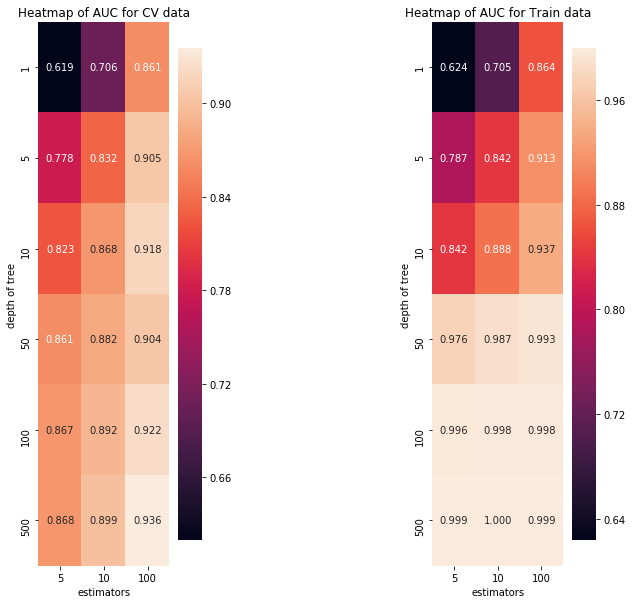

In [38]:
#hyperparameter tunning for Random Forest
depth, estimators = clf(bowTrain,AmazonReviewDataSampledTrain['Score'],'Random Forest')
print('The optimal depth is %r and number of estimator is %r'%(depth, estimators))
print('='*117)

AUC for Train data is   0.9985256736146415 

AUC for the Test data is   0.7783839940763575 



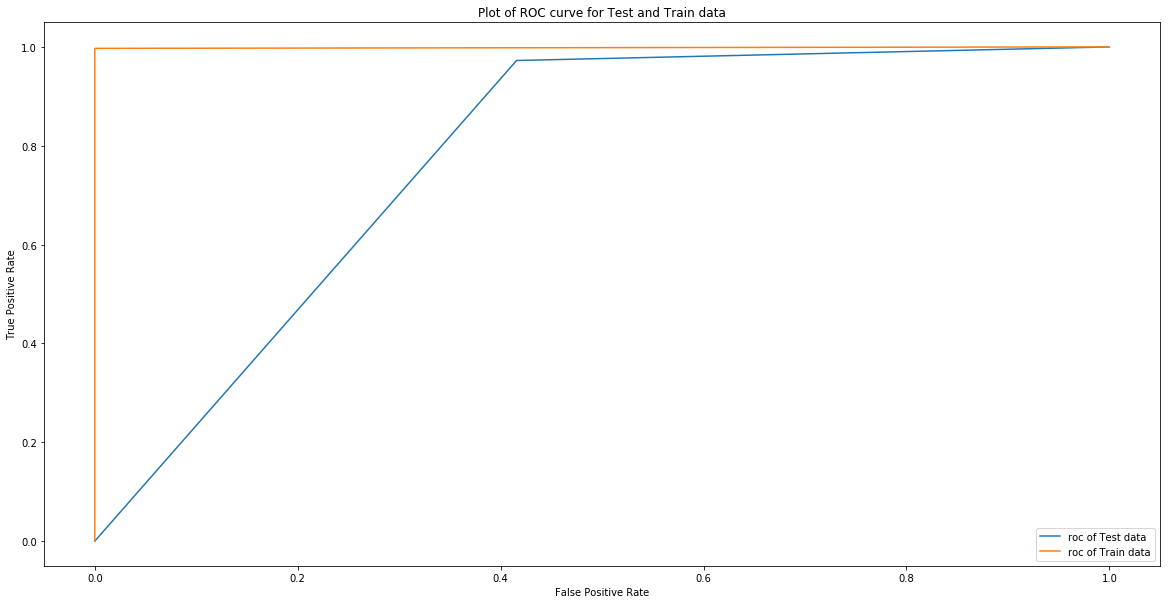

True positive rate = 97.24792408066429
True negative rate = 58.42887473460722


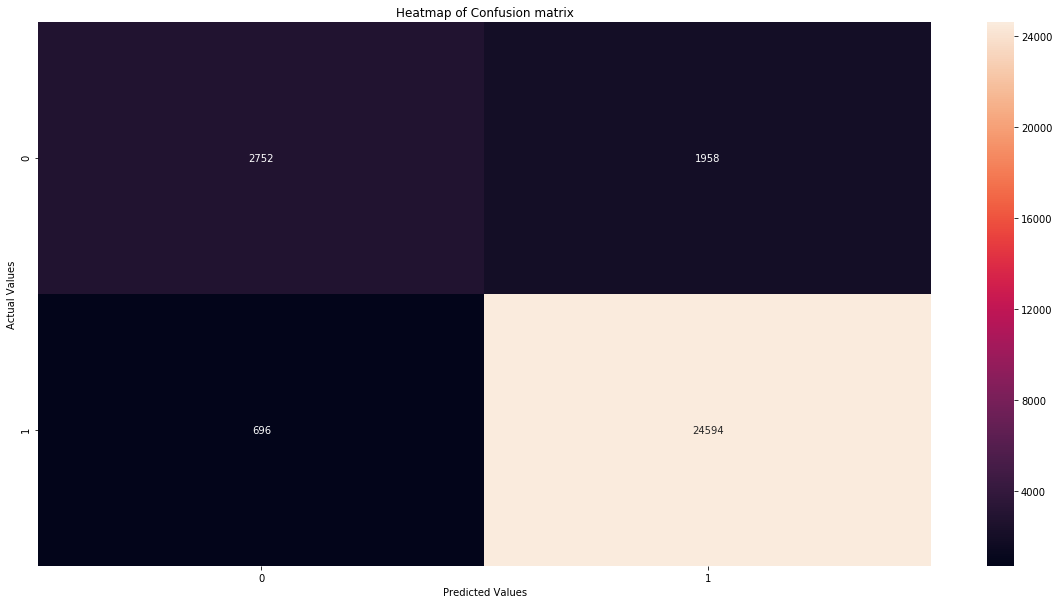

In [39]:
# Random forest classifier using optimal depth and number of estimators
auc_test,auc_train,TPR,TNR,coef = clfperformance(bowTrain,AmazonReviewDataSampledTrain['Score'],bowTest,AmazonReviewDataSampledTest['Score'],estimators,depth,'Random Forest')
table1.add_row(['Bag of Words',depth,estimators,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

20 Most important features in Positive and Negative Class


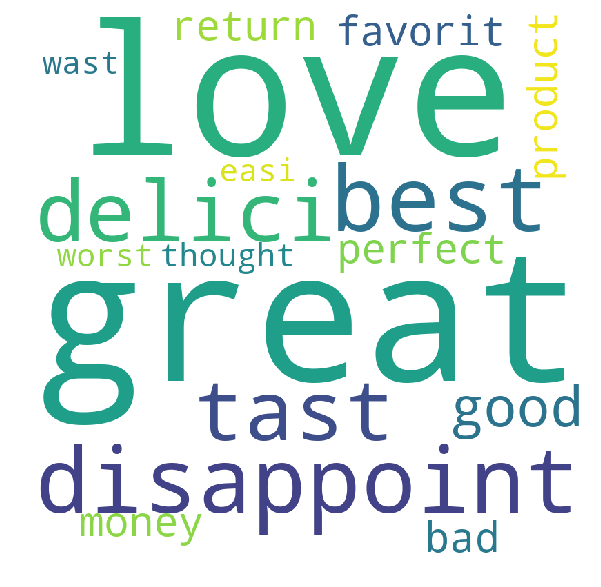

In [40]:
# Word cloud for top 20 features of bag of words vectorizer
TopFeatures(20,bagofwords,coef)

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

For depth = 1
Number of Estimators = 5 , the auc for train data = 0.63974 and cv data = 0.63794
Number of Estimators = 10 , the auc for train data = 0.70105 and cv data = 0.6966
Number of Estimators = 100 , the auc for train data = 0.87245 and cv data = 0.86608
For depth = 5
Number of Estimators = 5 , the auc for train data = 0.80026 and cv data = 0.7888
Number of Estimators = 10 , the auc for train data = 0.847 and cv data = 0.83387
Number of Estimators = 100 , the auc for train data = 0.91964 and cv data = 0.90859
For depth = 10
Number of Estimators = 5 , the auc for train data = 0.85079 and cv data = 0.82435
Number of Estimators = 10 , the auc for train data = 0.89449 and cv data = 0.87153
Number of Estimators = 100 , the auc for train data = 0.9401 and cv data = 0.91895
For depth = 50
Number of Estimators = 5 , the auc for train data = 0.97957 and cv data = 0.88838
Number of Estimators = 10 , the auc for train data = 0.98958 and cv data = 0.91305
Number of Estimators = 100 , the au

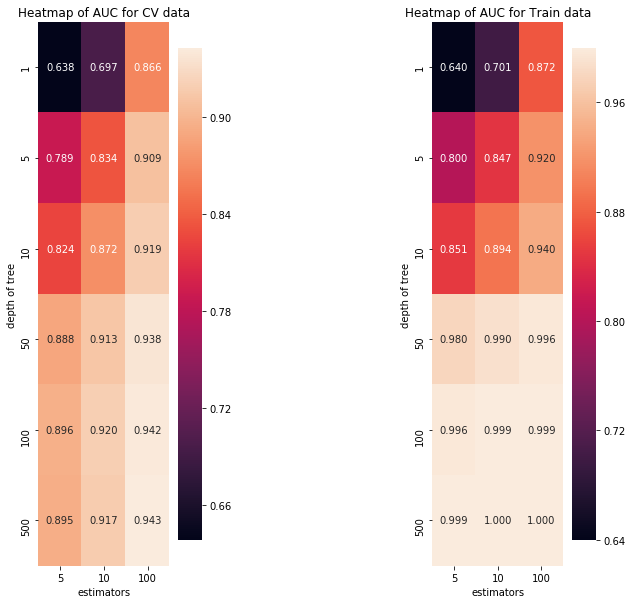

In [41]:
#hyperparameter tunning of Random forest classifier
depth, estimators = clf(tfidfTrain,AmazonReviewDataSampledTrain['Score'],'Random Forest')
print('The optimal depth is %r and number of estimator is %r'%(depth, estimators))
print('='*117)

AUC for Train data is   0.9985002541942043 

AUC for the Test data is   0.8069570057397879 



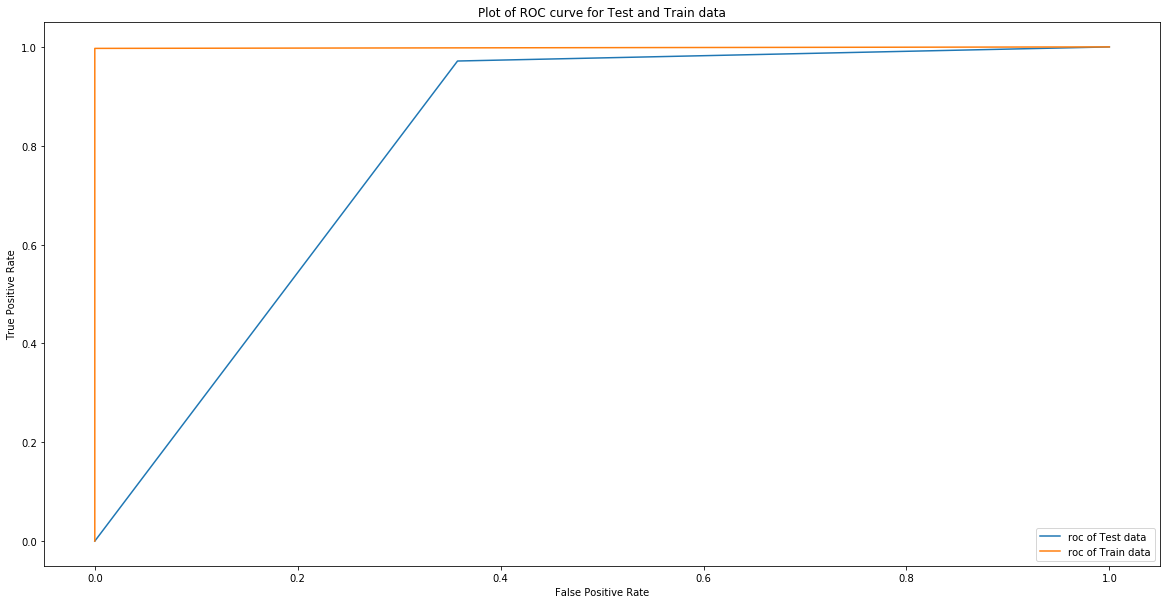

True positive rate = 97.145116646896
True negative rate = 64.24628450106157


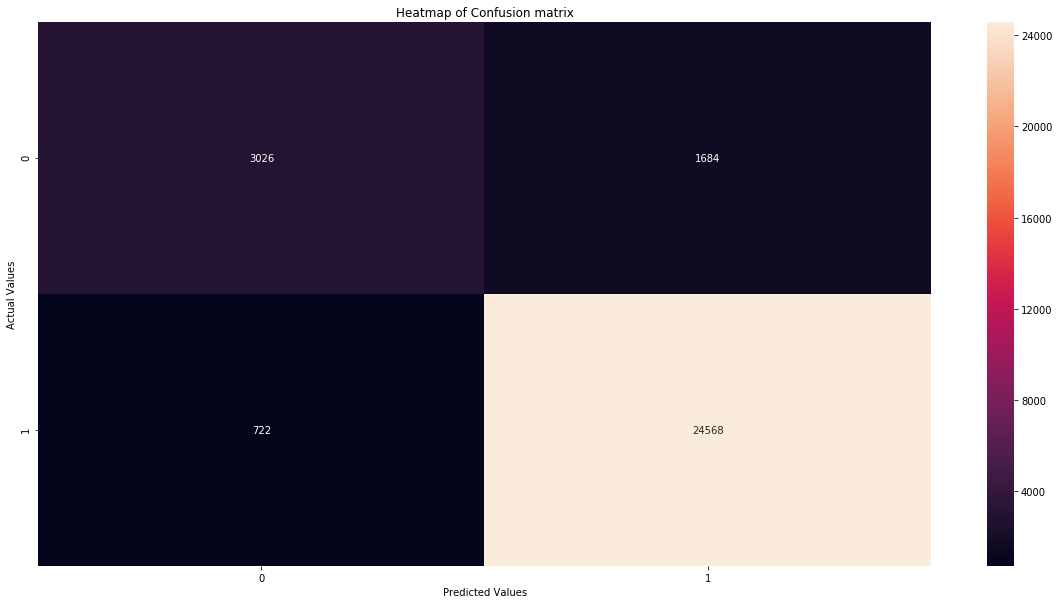

In [42]:
# Random forest classifier using optimal depth and number of estimators
auc_test,auc_train,TPR,TNR,coef = clfperformance(tfidfTrain,AmazonReviewDataSampledTrain['Score'],tfidfTest,AmazonReviewDataSampledTest['Score'],estimators,depth,'Random Forest')
table1.add_row(['TFIDF',depth,estimators,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

20 Most important features in Positive and Negative Class


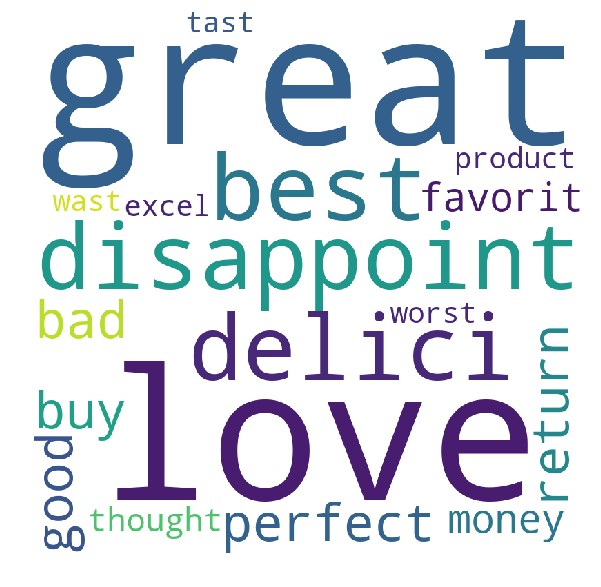

In [43]:
# Word cloud of top 20 features for TFIDF vectorizer
TopFeatures(20,tfidfVec,coef)

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

For depth = 1
Number of Estimators = 5 , the auc for train data = 0.77622 and cv data = 0.77755
Number of Estimators = 10 , the auc for train data = 0.7997 and cv data = 0.79452
Number of Estimators = 100 , the auc for train data = 0.81697 and cv data = 0.81339
For depth = 5
Number of Estimators = 5 , the auc for train data = 0.85588 and cv data = 0.84431
Number of Estimators = 10 , the auc for train data = 0.86341 and cv data = 0.85085
Number of Estimators = 100 , the auc for train data = 0.86881 and cv data = 0.85646
For depth = 10
Number of Estimators = 5 , the auc for train data = 0.9354 and cv data = 0.86245
Number of Estimators = 10 , the auc for train data = 0.94235 and cv data = 0.8688
Number of Estimators = 100 , the auc for train data = 0.94843 and cv data = 0.87622
For depth = 50
Number of Estimators = 5 , the auc for train data = 0.99771 and cv data = 0.83135
Number of Estimators = 10 , the auc for train data = 0.99941 and cv data = 0.8567
Number of Estimators = 100 , the a

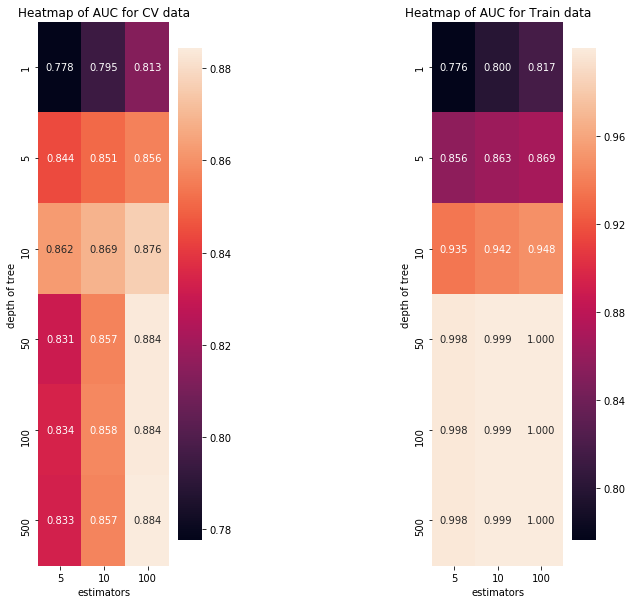

In [44]:
#hyperparameter tunning for random forest
depth, estimators = clf(avgW2VTrain,AmazonReviewDataSampledTrain['Score'],'Random Forest')
print('The optimal depth is %r and number of estimator is %r'%(depth, estimators))
print('='*117)

AUC for Train data is   0.9980565207019861 

AUC for the Test data is   0.6698083127441425 



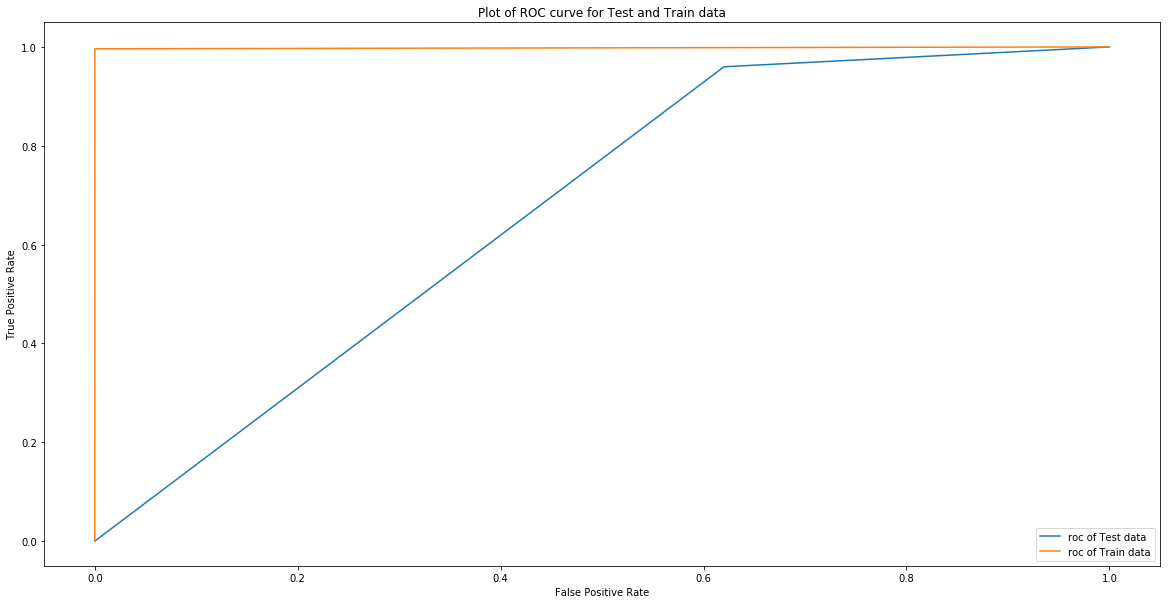

True positive rate = 95.97864768683274
True negative rate = 37.983014861995755


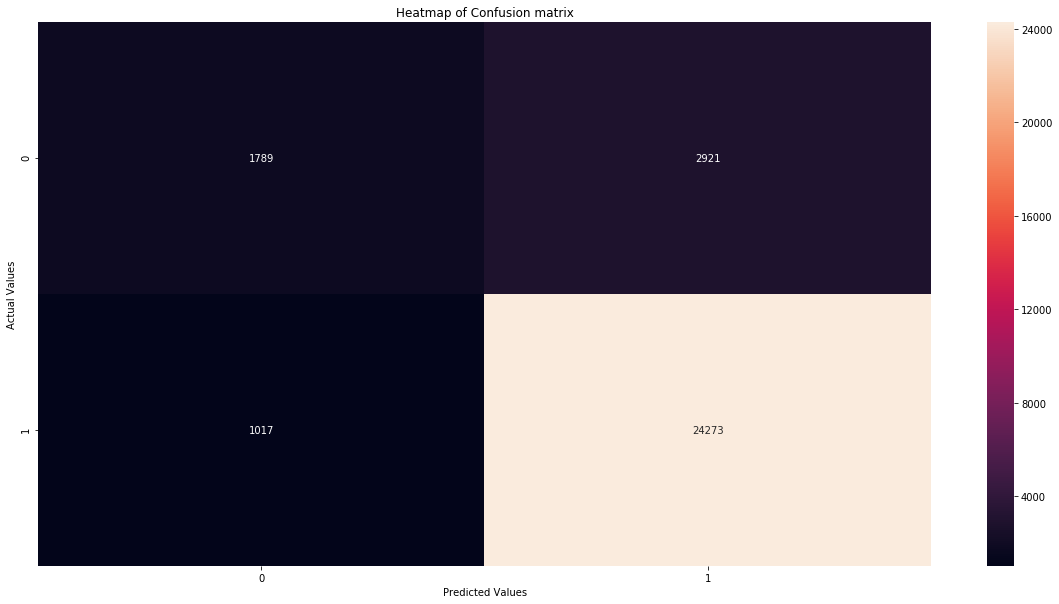

In [45]:
# Random forest classifier using optimal depth and number of estimators
auc_test,auc_train,TPR,TNR,coef = clfperformance(avgW2VTrain,AmazonReviewDataSampledTrain['Score'],avgW2VTest,AmazonReviewDataSampledTest['Score'],estimators,depth,'Random Forest')
table1.add_row(['Avg W2V',depth,estimators,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])

In [46]:
# Please write all the code with proper documentation

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

For depth = 1
Number of Estimators = 5 , the auc for train data = 0.73684 and cv data = 0.73353
Number of Estimators = 10 , the auc for train data = 0.75336 and cv data = 0.74691
Number of Estimators = 100 , the auc for train data = 0.775 and cv data = 0.77126
For depth = 5
Number of Estimators = 5 , the auc for train data = 0.81669 and cv data = 0.80054
Number of Estimators = 10 , the auc for train data = 0.82719 and cv data = 0.81132
Number of Estimators = 100 , the auc for train data = 0.83284 and cv data = 0.81668
For depth = 10
Number of Estimators = 5 , the auc for train data = 0.92098 and cv data = 0.82328
Number of Estimators = 10 , the auc for train data = 0.92984 and cv data = 0.8363
Number of Estimators = 100 , the auc for train data = 0.93918 and cv data = 0.84423
For depth = 50
Number of Estimators = 5 , the auc for train data = 0.99763 and cv data = 0.79364
Number of Estimators = 10 , the auc for train data = 0.99947 and cv data = 0.82265
Number of Estimators = 100 , the 

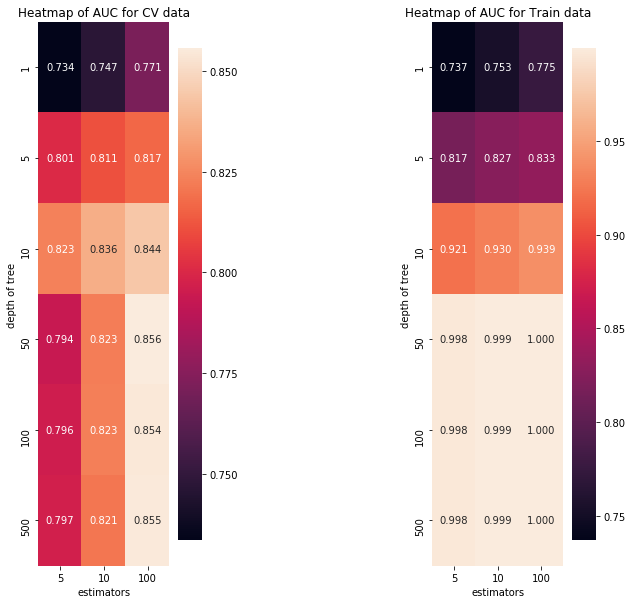

In [47]:
#hyperparameter tunning using Random forest
depth, estimators = clf(tfidfw2vTrain,AmazonReviewDataSampledTrain['Score'],'Random Forest')
print('The optimal depth is %r and number of estimator is %r'%(depth, estimators))
print('='*117)

AUC for Train data is   0.9982344566450466 

AUC for the Test data is   0.6305921375735732 



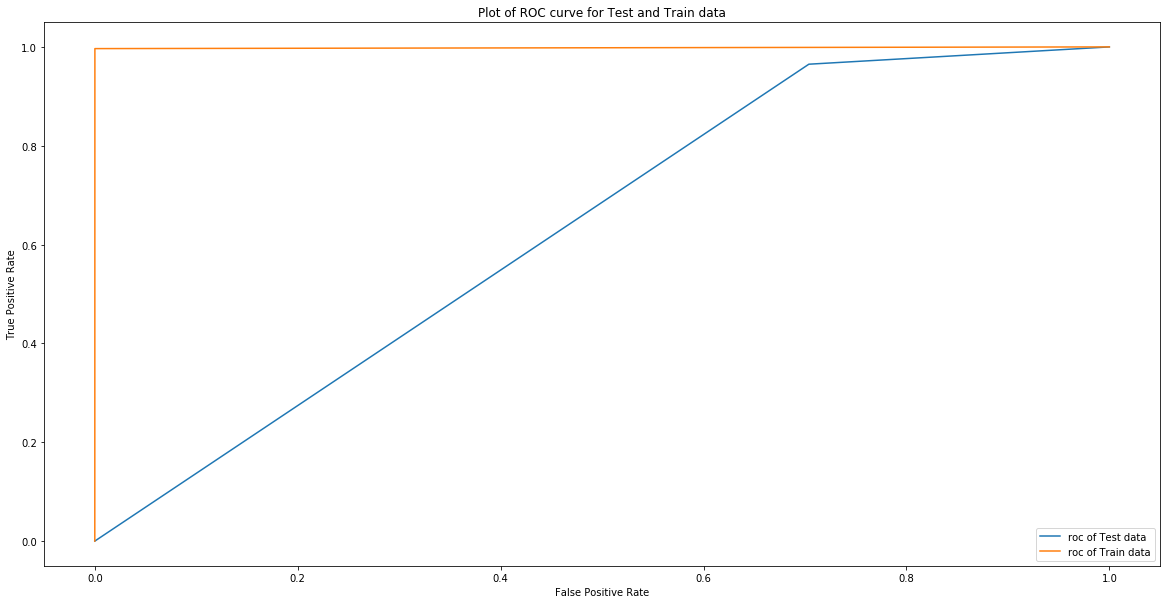

True positive rate = 96.50059311981019
True negative rate = 29.617834394904456


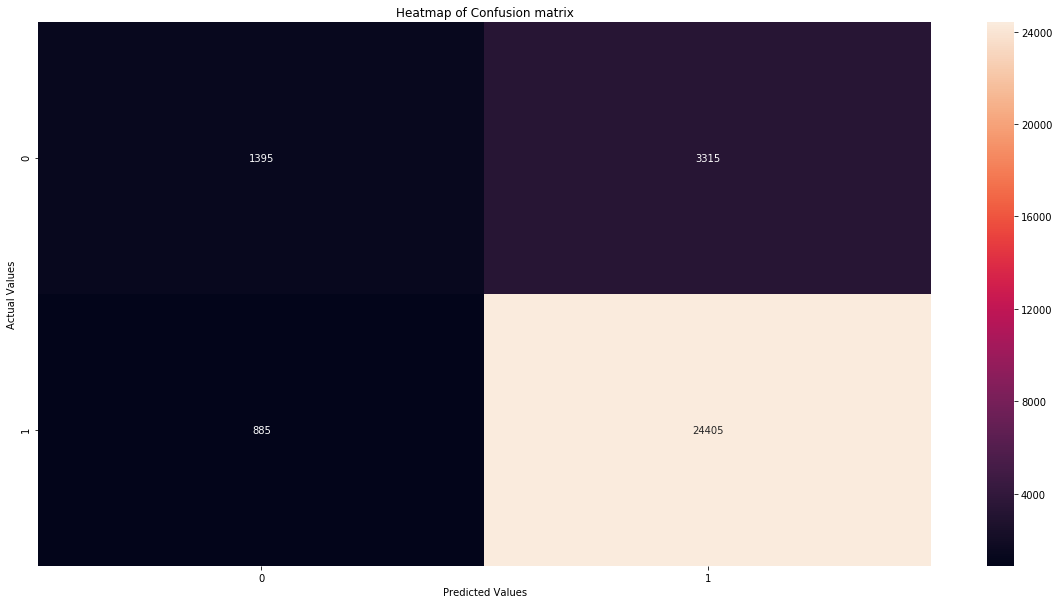

In [48]:
# Random forest classifier using optimal depth and number of estimators
auc_test,auc_train,TPR,TNR,coef = clfperformance(tfidfw2vTrain,AmazonReviewDataSampledTrain['Score'],tfidfw2vTest,AmazonReviewDataSampledTest['Score'],estimators,depth,'Random Forest')
table1.add_row(['TFIDF W2V',depth,estimators,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])

In [49]:
# Please write all the code with proper documentation

## [5.2] Applying GBDT using XGBOOST

In [50]:
#pretty table initialization for Xgboost
table2 = PrettyTable()
table2.field_names = ['Vectorizer','Optimal Depth','Number of Estimators','AUC','TPR','TNR']

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

For depth = 1
Number of Estimators = 5 , the auc for train data = 0.62162 and cv data = 0.62153
Number of Estimators = 10 , the auc for train data = 0.62162 and cv data = 0.62153
Number of Estimators = 100 , the auc for train data = 0.66612 and cv data = 0.666
For depth = 5
Number of Estimators = 5 , the auc for train data = 0.76207 and cv data = 0.7572
Number of Estimators = 10 , the auc for train data = 0.76251 and cv data = 0.75762
Number of Estimators = 100 , the auc for train data = 0.76898 and cv data = 0.76317
For depth = 10
Number of Estimators = 5 , the auc for train data = 0.83381 and cv data = 0.80829
Number of Estimators = 10 , the auc for train data = 0.83404 and cv data = 0.80833
Number of Estimators = 100 , the auc for train data = 0.83845 and cv data = 0.81186
For depth = 50
Number of Estimators = 5 , the auc for train data = 0.91553 and cv data = 0.83926
Number of Estimators = 10 , the auc for train data = 0.91611 and cv data = 0.83982
Number of Estimators = 100 , the 

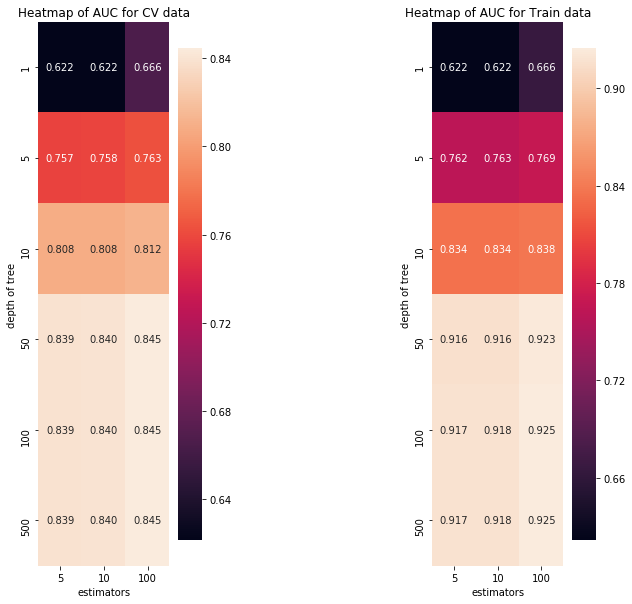

In [51]:
#hyperparameter tunning for Xgboost classifier
depth, estimators = clf(bowTrain,AmazonReviewDataSampledTrain['Score'],'Xgboost')
print('The optimal depth is %r and number of estimator is %r'%(depth, estimators))
print('='*117)

AUC for Train data is   0.6528721246641775 

AUC for the Test data is   0.6324403794959363 



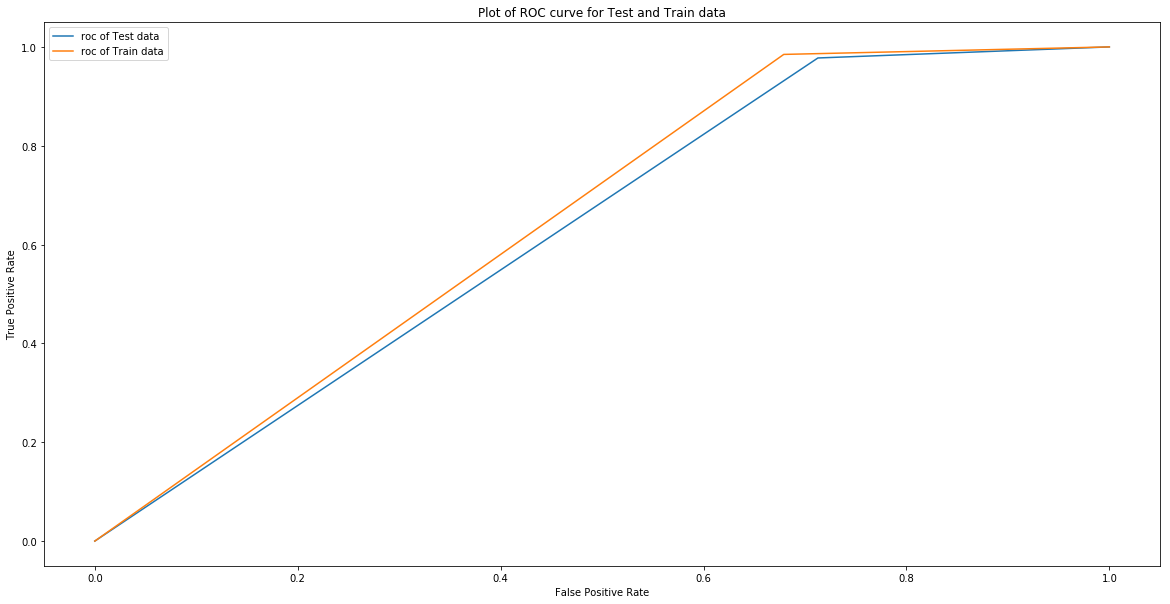

True positive rate = 97.76196124950573
True negative rate = 28.726114649681527


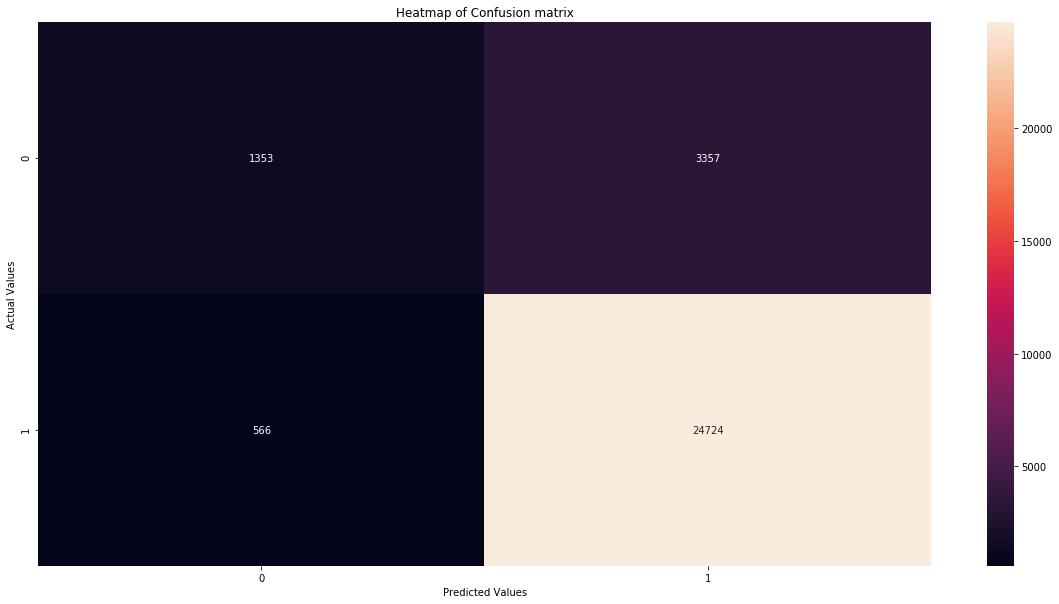

In [52]:
# Xgboost classifier using optimal depth and number of estimators
auc_test,auc_train,TPR,TNR,coef = clfperformance(bowTrain,AmazonReviewDataSampledTrain['Score'],bowTest,AmazonReviewDataSampledTest['Score'],estimators,depth,'Xgboost')
table2.add_row(['Bag of Words',depth,estimators,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])

20 Most important features in Positive and Negative Class


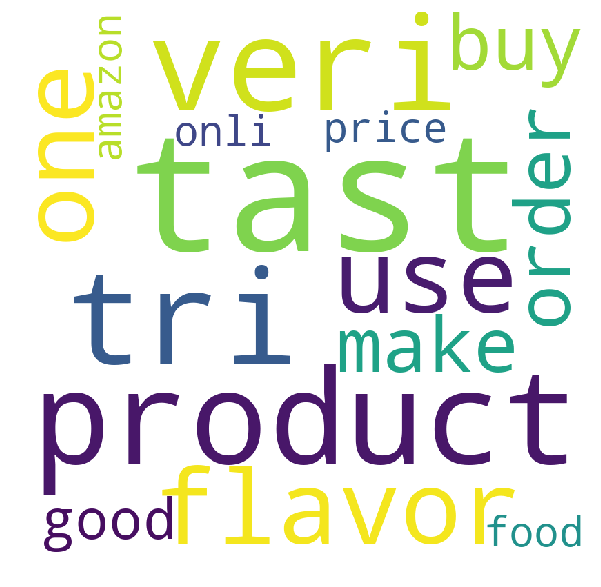

In [53]:
# Word cloud of top 20 features for Bag of words vectorizer
TopFeatures(20,bagofwords,coef)

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

For depth = 1
Number of Estimators = 5 , the auc for train data = 0.63362 and cv data = 0.63198
Number of Estimators = 10 , the auc for train data = 0.63363 and cv data = 0.63198
Number of Estimators = 100 , the auc for train data = 0.67128 and cv data = 0.67005
For depth = 5
Number of Estimators = 5 , the auc for train data = 0.77254 and cv data = 0.76467
Number of Estimators = 10 , the auc for train data = 0.77284 and cv data = 0.76487
Number of Estimators = 100 , the auc for train data = 0.78142 and cv data = 0.77304
For depth = 10
Number of Estimators = 5 , the auc for train data = 0.84463 and cv data = 0.81397
Number of Estimators = 10 , the auc for train data = 0.8452 and cv data = 0.81431
Number of Estimators = 100 , the auc for train data = 0.85389 and cv data = 0.82292
For depth = 50
Number of Estimators = 5 , the auc for train data = 0.94 and cv data = 0.85055
Number of Estimators = 10 , the auc for train data = 0.94143 and cv data = 0.85193
Number of Estimators = 100 , the a

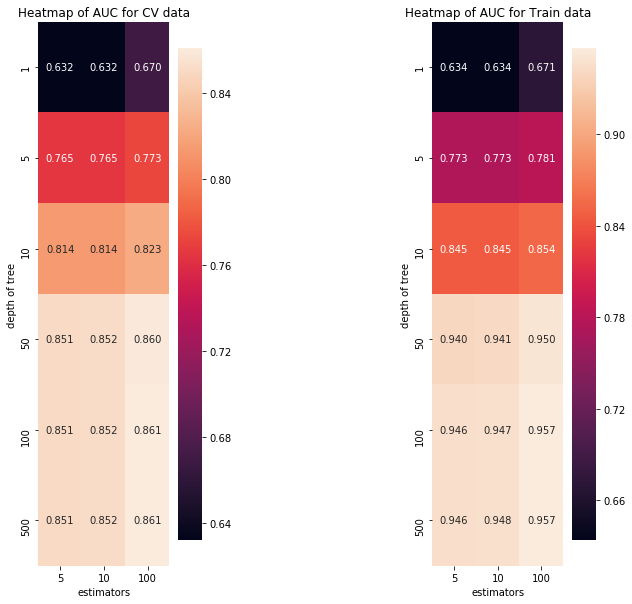

In [54]:
#hyperparameter tunning for Xgboost classifier
depth, estimators = clf(tfidfTrain,AmazonReviewDataSampledTrain['Score'],'Xgboost')
print('The optimal depth is %r and number of estimator is %r'%(depth, estimators))
print('='*117)

AUC for Train data is   0.7166327201370382 

AUC for the Test data is   0.6649631157553274 



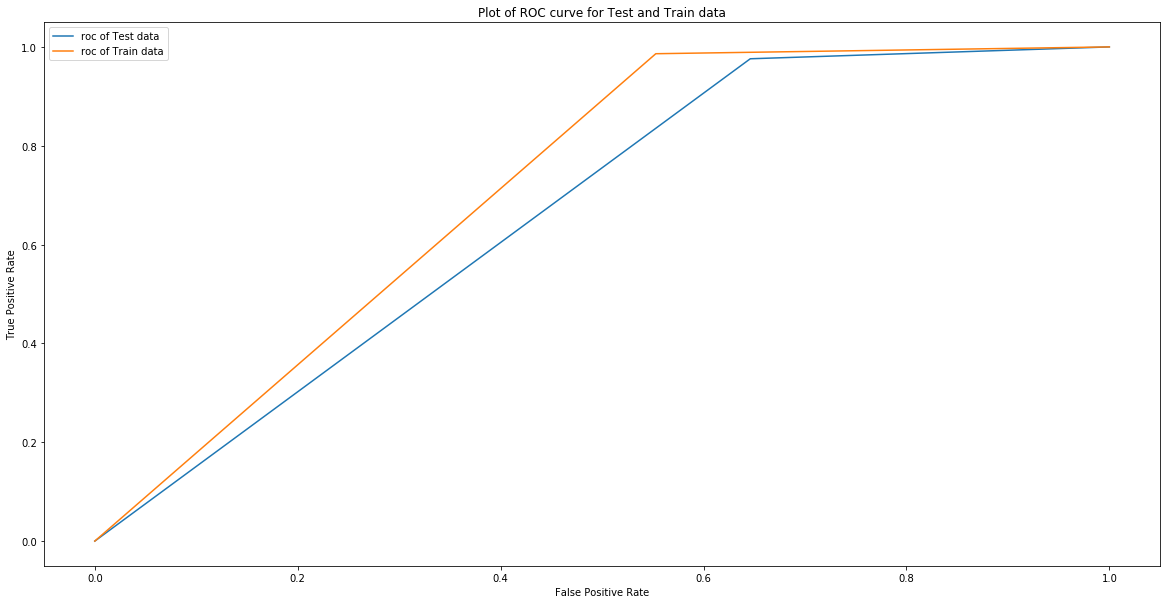

True positive rate = 97.59984183471728
True negative rate = 35.39278131634819


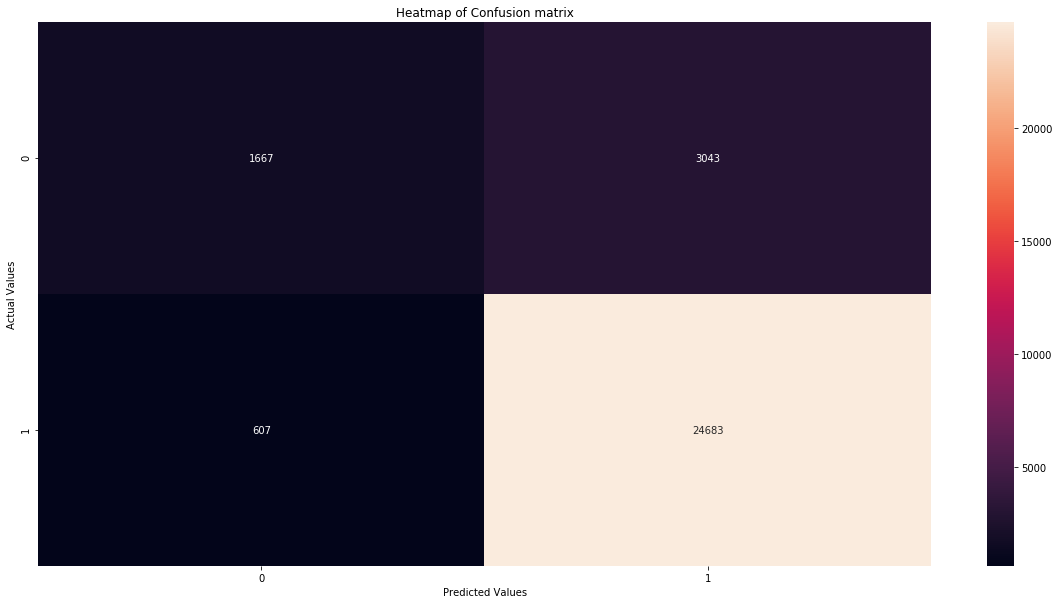

In [55]:
# Xgboost classifier using optimal depth and number of estimators
auc_test,auc_train,TPR,TNR,coef = clfperformance(tfidfTrain,AmazonReviewDataSampledTrain['Score'],tfidfTest,AmazonReviewDataSampledTest['Score'],estimators,depth,'Xgboost')
table2.add_row(['TFIDF',depth,estimators,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])

In [56]:
# Please write all the code with proper documentation

20 Most important features in Positive and Negative Class


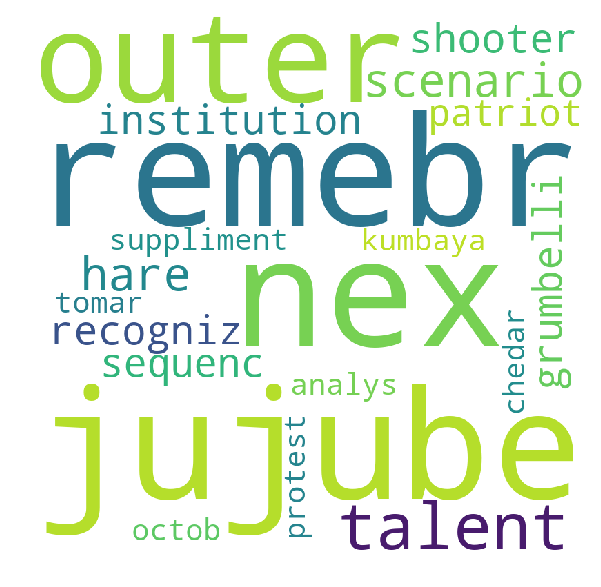

In [57]:
# Word cloud for top 20 features for TFIDF vectorizer
TopFeatures(20,tfidfVec,coef)

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

For depth = 1
Number of Estimators = 5 , the auc for train data = 0.65024 and cv data = 0.64945
Number of Estimators = 10 , the auc for train data = 0.65024 and cv data = 0.64945
Number of Estimators = 100 , the auc for train data = 0.65834 and cv data = 0.65729
For depth = 5
Number of Estimators = 5 , the auc for train data = 0.82505 and cv data = 0.81175
Number of Estimators = 10 , the auc for train data = 0.82616 and cv data = 0.81283
Number of Estimators = 100 , the auc for train data = 0.83558 and cv data = 0.82228
For depth = 10
Number of Estimators = 5 , the auc for train data = 0.91815 and cv data = 0.84017
Number of Estimators = 10 , the auc for train data = 0.91899 and cv data = 0.84075
Number of Estimators = 100 , the auc for train data = 0.93413 and cv data = 0.85374
For depth = 50
Number of Estimators = 5 , the auc for train data = 0.94843 and cv data = 0.83836
Number of Estimators = 10 , the auc for train data = 0.94927 and cv data = 0.83908
Number of Estimators = 100 , t

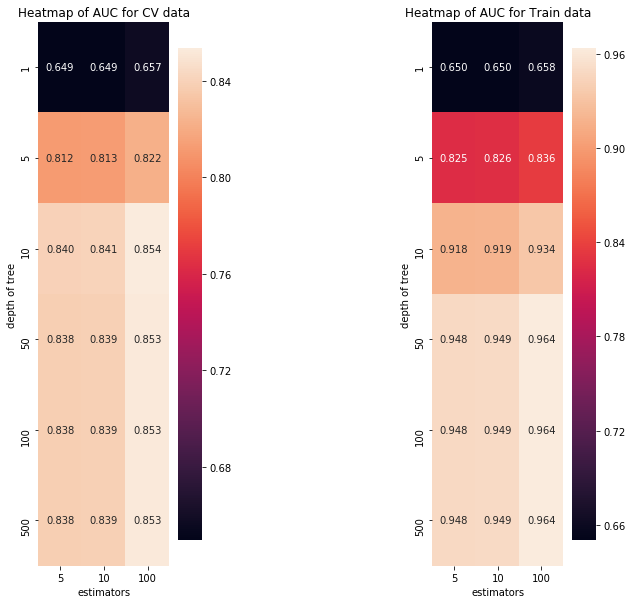

In [58]:
#hyperparameter tunning for Xgboost classifier
depth, estimators = clf(avgW2VTrain,AmazonReviewDataSampledTrain['Score'],'Xgboost')
print('The optimal depth is %r and number of estimator is %r'%(depth, estimators))
print('='*117)

AUC for Train data is   0.6523861873783672 

AUC for the Test data is   0.6237212664304261 



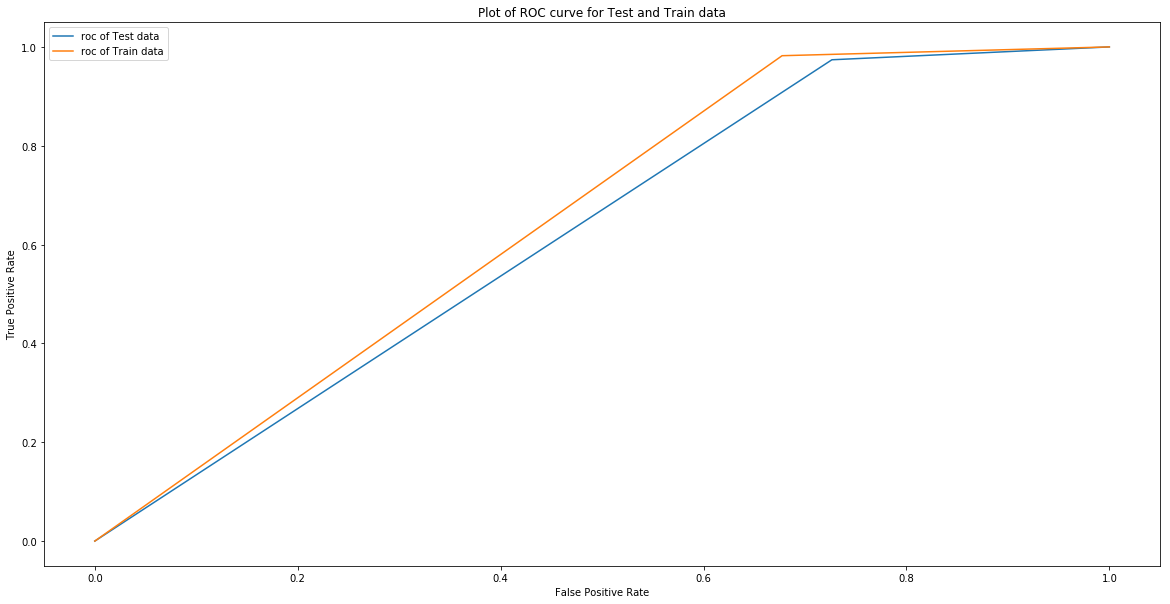

True positive rate = 97.39818109924872
True negative rate = 27.34607218683652


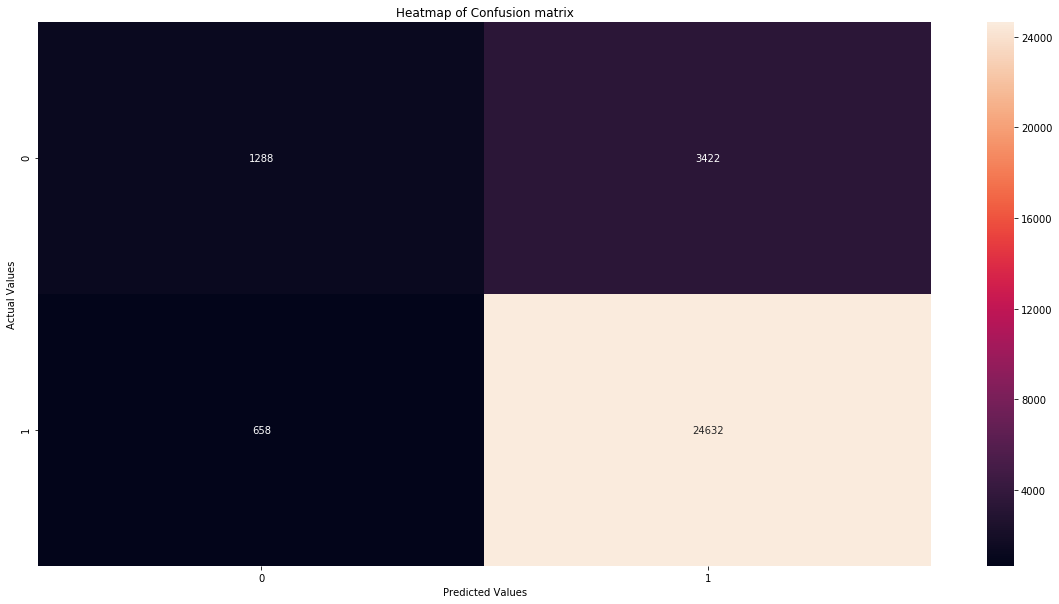

In [59]:
# Xgboost classifier using optimal depth and number of estimators
auc_test,auc_train,TPR,TNR,coef = clfperformance(avgW2VTrain,AmazonReviewDataSampledTrain['Score'],avgW2VTest,AmazonReviewDataSampledTest['Score'],estimators,depth,'Xgboost')
table2.add_row(['Avg W2V',depth,estimators,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

For depth = 1
Number of Estimators = 5 , the auc for train data = 0.62342 and cv data = 0.6229
Number of Estimators = 10 , the auc for train data = 0.62352 and cv data = 0.62297
Number of Estimators = 100 , the auc for train data = 0.63448 and cv data = 0.63283
For depth = 5
Number of Estimators = 5 , the auc for train data = 0.78217 and cv data = 0.7678
Number of Estimators = 10 , the auc for train data = 0.78258 and cv data = 0.76825
Number of Estimators = 100 , the auc for train data = 0.7902 and cv data = 0.77509
For depth = 10
Number of Estimators = 5 , the auc for train data = 0.90051 and cv data = 0.80409
Number of Estimators = 10 , the auc for train data = 0.9018 and cv data = 0.80525
Number of Estimators = 100 , the auc for train data = 0.91623 and cv data = 0.81671
For depth = 50
Number of Estimators = 5 , the auc for train data = 0.9425 and cv data = 0.80116
Number of Estimators = 10 , the auc for train data = 0.9447 and cv data = 0.80319
Number of Estimators = 100 , the auc

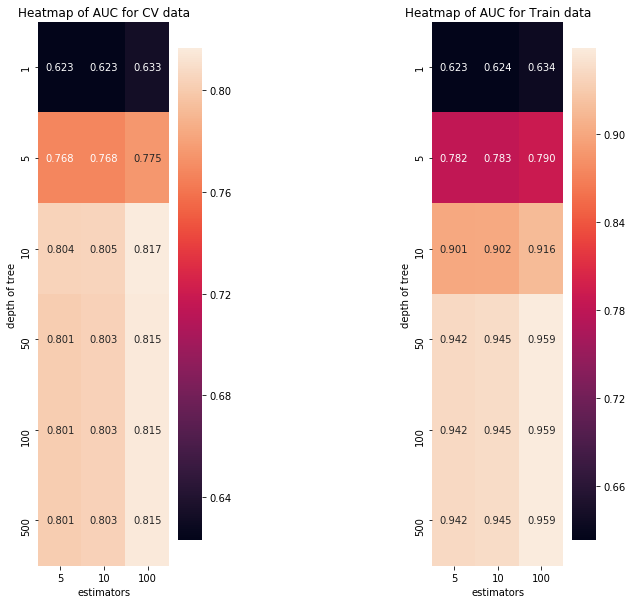

In [60]:
#hyperparamter tunning for Xgboost classifier
depth, estimators = clf(tfidfw2vTrain,AmazonReviewDataSampledTrain['Score'],'Xgboost')
print('The optimal depth is %r and number of estimator is %r'%(depth, estimators))
print('='*117)

AUC for Train data is   0.5657116304372464 

AUC for the Test data is   0.5590150433317467 



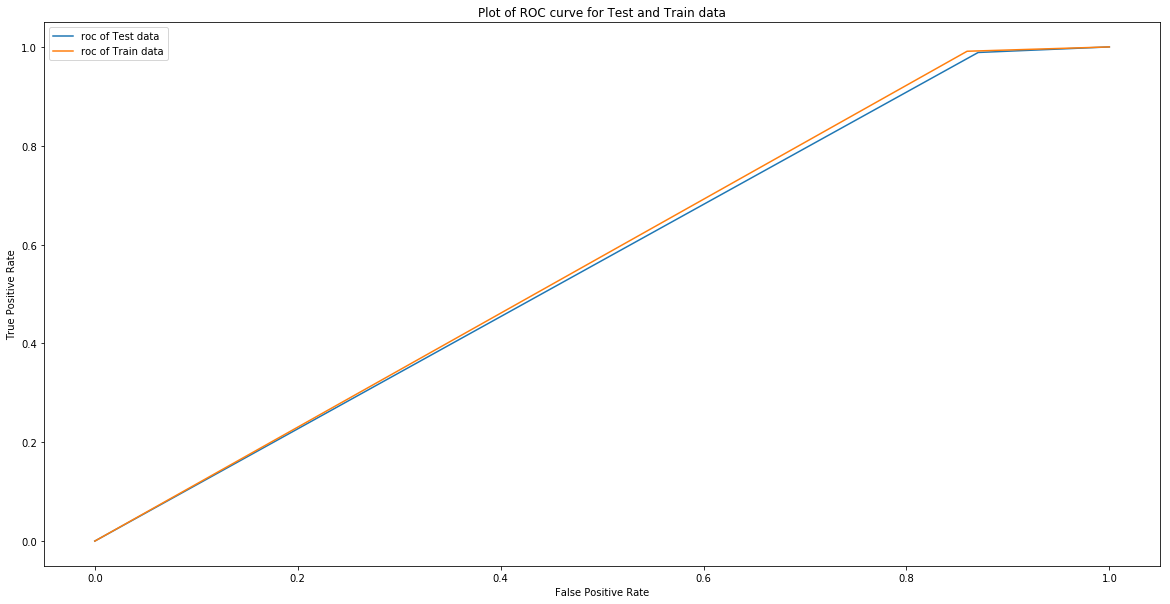

True positive rate = 98.87307236061685
True negative rate = 12.929936305732484


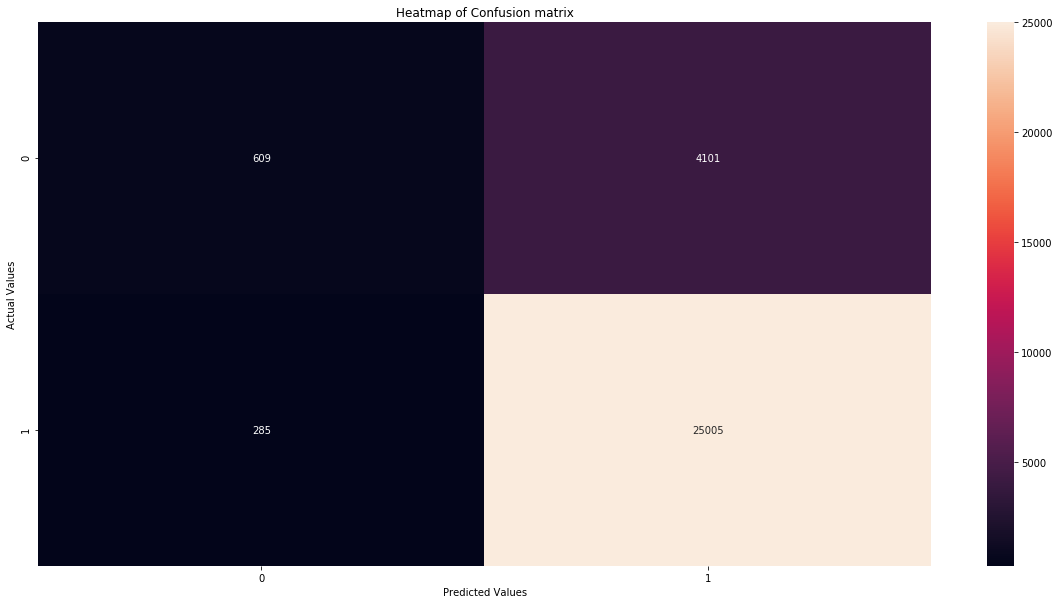

In [66]:
# Xgboost classifier using optimal depth and minimum samples split
auc_test,auc_train,TPR,TNR,coef = clfperformance(tfidfw2vTrain,AmazonReviewDataSampledTrain['Score'],tfidfw2vTest,AmazonReviewDataSampledTest['Score'],estimators,depth,'Xgboost')
table2.add_row(['TFIDF W2V',depth,estimators,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])

# [6] Feature Engineering to improve the performance of Random Forest and Xgboost model using summary and text review 

# [6.1] Random Forest

In [39]:
#Pretty table for summarizing the results
table3 = PrettyTable()
table3.field_names = ['Vectorizer','Optimal Depth','Number of Estimators','AUC','TPR','TNR']

## [6.1.1] Applying Random Forest on BOW,<font color='red'> SET 1</font>

In [40]:
#combining the bow for text and summary review
combined_features = FeatureUnion([( 'count_v01', bagofwords),('count_v02',bagofwordsSum)])

bowTrainFE = combined_features.transform(AmazonReviewDataSampledTrain['Text'] + ' ' +AmazonReviewDataSampledTrain['Summary'])
bowTestFE  = combined_features.transform(AmazonReviewDataSampledTest['Text'] + ' '+ AmazonReviewDataSampledTest['Summary'])


For depth = 1
Number of Estimators = 5 , the auc for train data = 0.68583 and cv data = 0.67981
Number of Estimators = 10 , the auc for train data = 0.74145 and cv data = 0.74117
Number of Estimators = 100 , the auc for train data = 0.90225 and cv data = 0.90145
For depth = 5
Number of Estimators = 5 , the auc for train data = 0.84514 and cv data = 0.83866
Number of Estimators = 10 , the auc for train data = 0.88275 and cv data = 0.87558
Number of Estimators = 100 , the auc for train data = 0.93431 and cv data = 0.9286
For depth = 10
Number of Estimators = 5 , the auc for train data = 0.89172 and cv data = 0.87293
Number of Estimators = 10 , the auc for train data = 0.92186 and cv data = 0.90594
Number of Estimators = 100 , the auc for train data = 0.95277 and cv data = 0.93775
For depth = 50
Number of Estimators = 5 , the auc for train data = 0.98885 and cv data = 0.90144
Number of Estimators = 10 , the auc for train data = 0.99353 and cv data = 0.9214
Number of Estimators = 100 , the

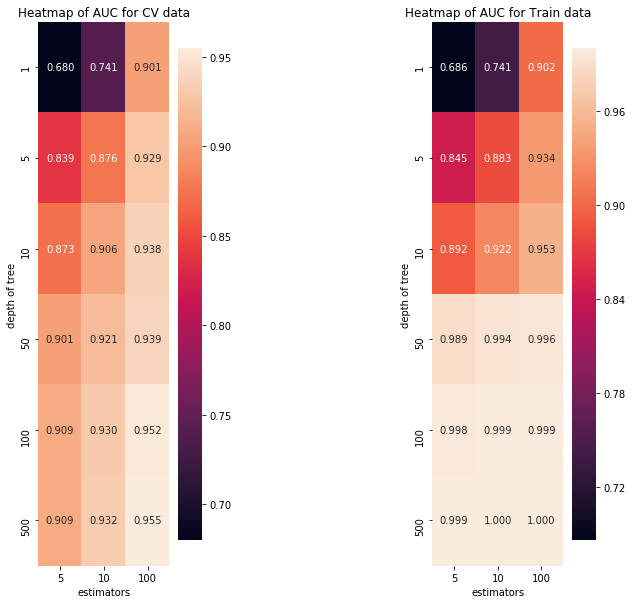

In [41]:
# Random forest classifier to find the optimal depth and number of estimators
depth, estimators = clf(bowTrainFE,AmazonReviewDataSampledTrain['Score'],'Random Forest')
print('The optimal depth is %r and number of estimator is %r'%(depth, estimators))
print('='*117)


AUC for Train data is   0.99850872733435 

AUC for the Test data is   0.7797038430637723 



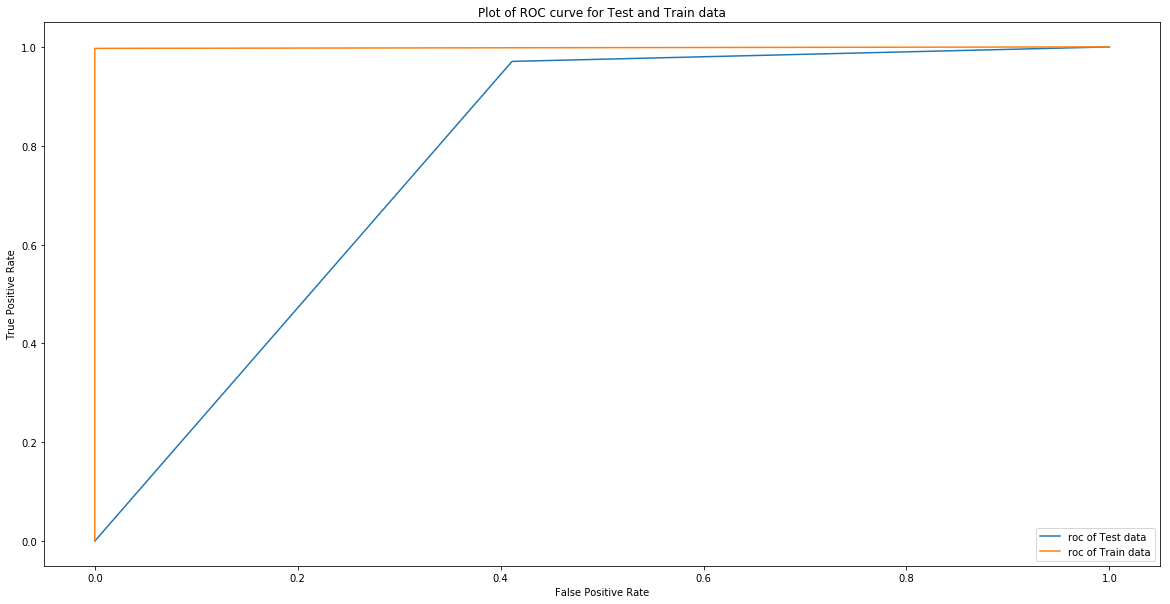

True positive rate = 97.06603400553578
True negative rate = 58.874734607218684


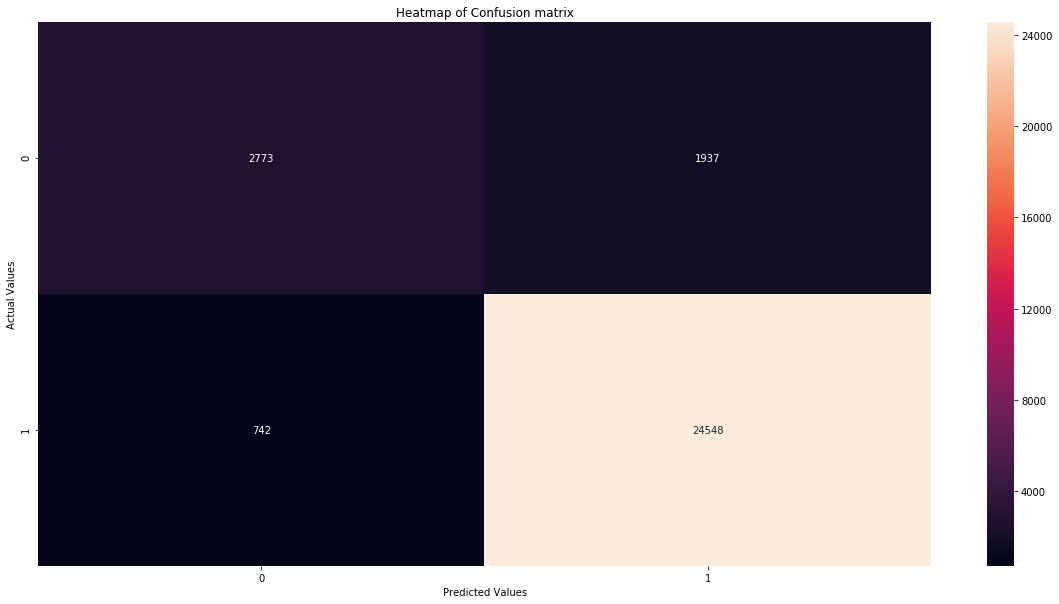

In [42]:
# Random forest classifier using optimal depth and number of estimators
auc_test,auc_train,TPR,TNR,coef = clfperformance(bowTrain,AmazonReviewDataSampledTrain['Score'],bowTest,AmazonReviewDataSampledTest['Score'],estimators,depth,'Random Forest')
table3.add_row(['Bag of Words',depth,estimators,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])

### [6.1.1] Top 20 important features from<font color='red'> SET 1</font>

20 Most important features in Positive and Negative Class


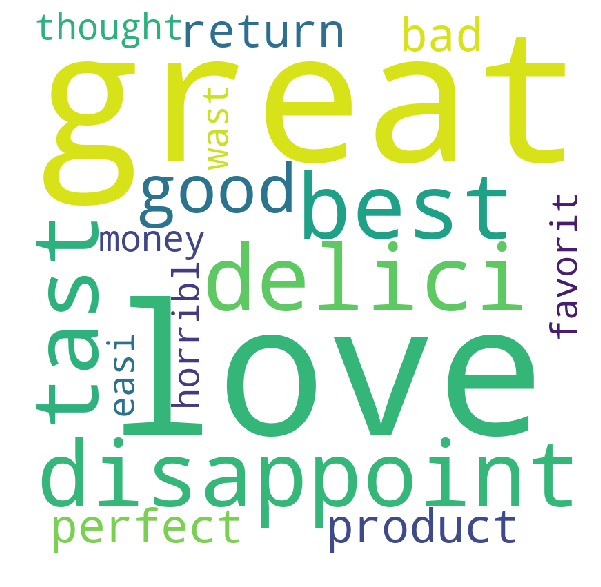

In [43]:
#word cloud for top 20 features uing bag of words vectorizer
TopFeatures(20,combined_features,coef)

## [6.1.2] Applying Random Forest on TFIDF,<font color='red'> SET 2</font>

In [44]:
# combining the TFIDF of text and summary review
combined_features = FeatureUnion([( 'count_v01', tfidfVec),('count_v02',tfidfVecSum)])

tfidfTrainFE = combined_features.transform(AmazonReviewDataSampledTrain['Text'] + ' ' +AmazonReviewDataSampledTrain['Summary'])
tfidfTestFE  = combined_features.transform(AmazonReviewDataSampledTest['Text'] + ' '+ AmazonReviewDataSampledTest['Summary'])


For depth = 1
Number of Estimators = 5 , the auc for train data = 0.68295 and cv data = 0.68462
Number of Estimators = 10 , the auc for train data = 0.75867 and cv data = 0.7541
Number of Estimators = 100 , the auc for train data = 0.90572 and cv data = 0.90399
For depth = 5
Number of Estimators = 5 , the auc for train data = 0.8542 and cv data = 0.84614
Number of Estimators = 10 , the auc for train data = 0.89481 and cv data = 0.88646
Number of Estimators = 100 , the auc for train data = 0.93686 and cv data = 0.92876
For depth = 10
Number of Estimators = 5 , the auc for train data = 0.90065 and cv data = 0.87783
Number of Estimators = 10 , the auc for train data = 0.92874 and cv data = 0.90974
Number of Estimators = 100 , the auc for train data = 0.95589 and cv data = 0.94068
For depth = 50
Number of Estimators = 5 , the auc for train data = 0.99068 and cv data = 0.92539
Number of Estimators = 10 , the auc for train data = 0.99526 and cv data = 0.9395
Number of Estimators = 100 , the 

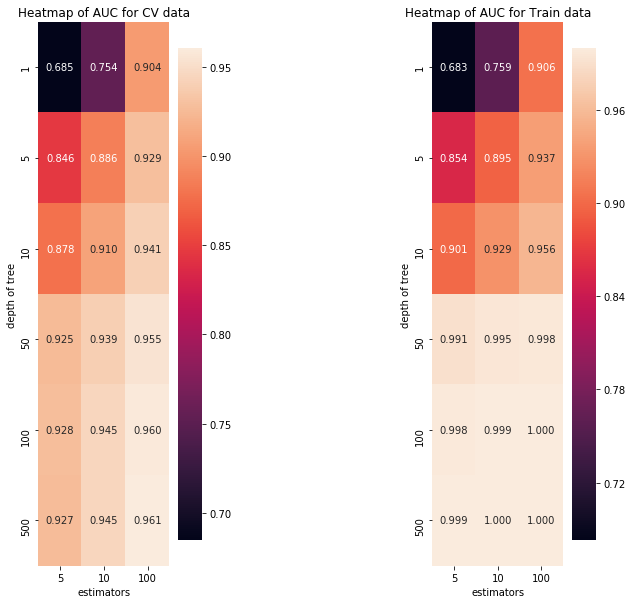

In [45]:
#hyperparameter tunning for Random forest
depth, estimators = clf(tfidfTrainFE,AmazonReviewDataSampledTrain['Score'],'Random Forest')
print('The optimal depth is %r and number of estimator is %r'%(depth, estimators))
print('='*117)

AUC for Train data is   0.9998612995530284 

AUC for the Test data is   0.842162507272329 



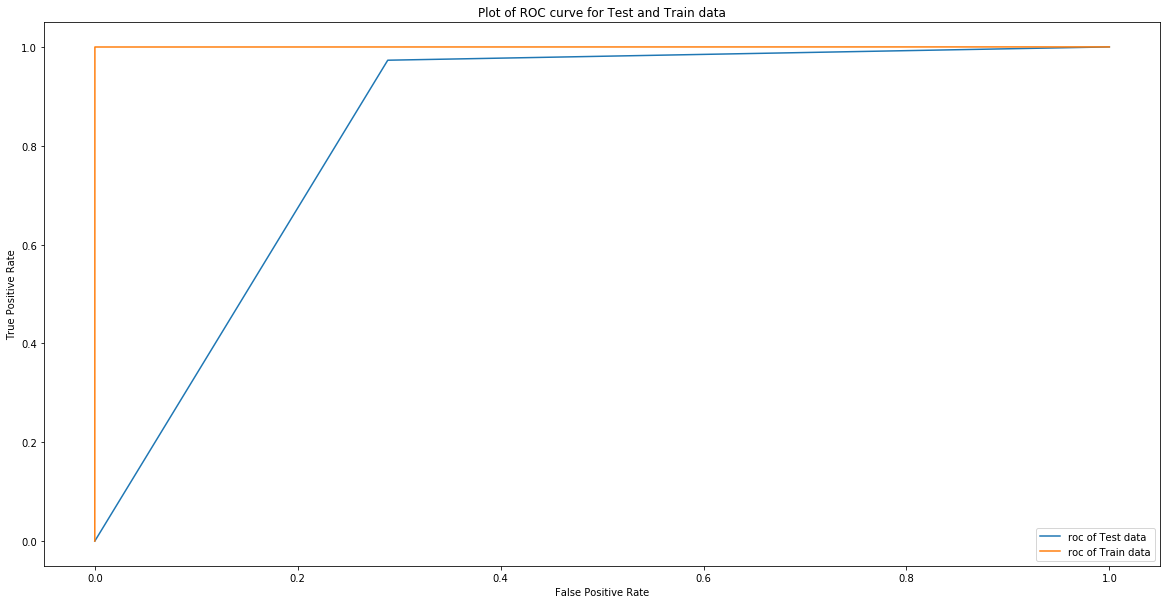

True positive rate = 97.30723606168446
True negative rate = 71.12526539278132


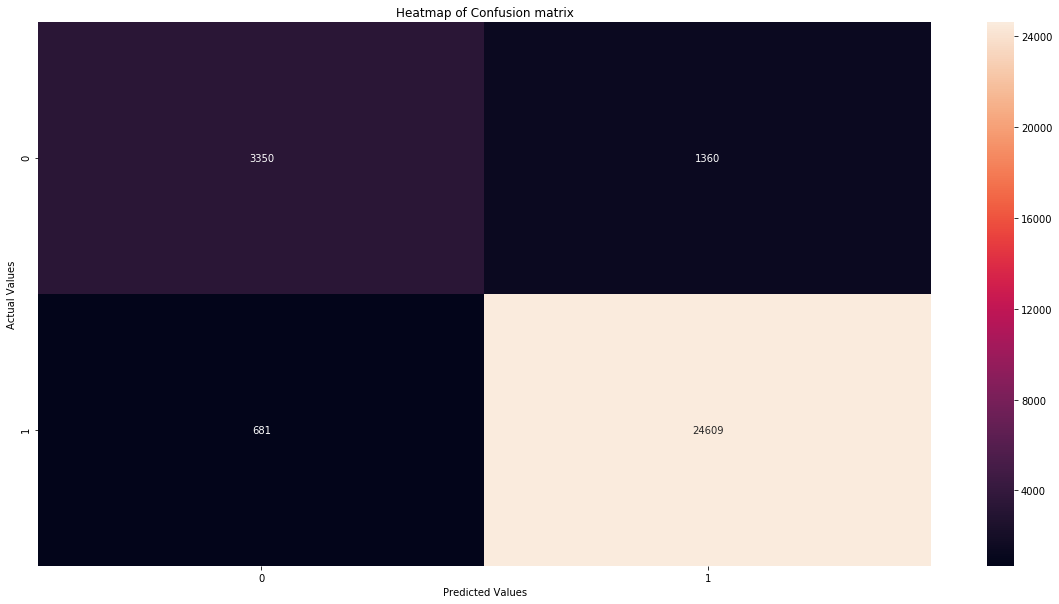

In [46]:
# Random forest classifier using optimal depth and number of estimators
auc_test,auc_train,TPR,TNR,coef = clfperformance(tfidfTrainFE,AmazonReviewDataSampledTrain['Score'],tfidfTestFE,AmazonReviewDataSampledTest['Score'],estimators,depth,'Random Forest')
table3.add_row(['TFIDF',depth,estimators,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])

### [6.1.2] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

20 Most important features in Positive and Negative Class


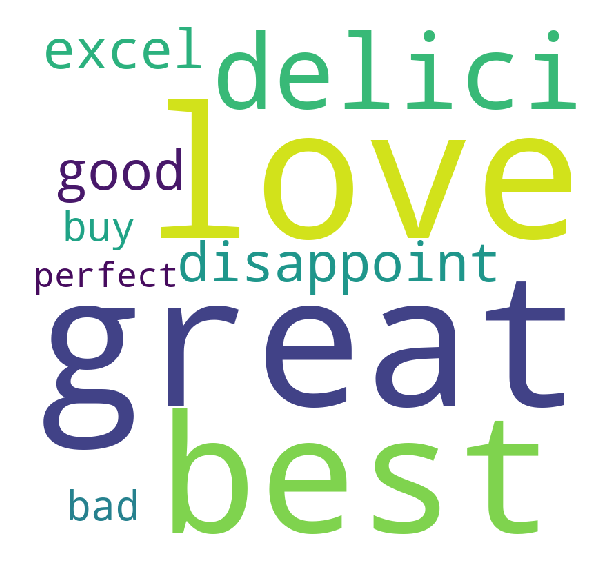

In [47]:
# Word cloud for top 20 features uing TFIDF vectorizer
TopFeatures(20,combined_features,coef)

## [6.1.3] Applying Random Forest on AVG W2V,<font color='red'> SET 3</font>

In [48]:
#Combining the w2v of text and summary 
avgW2VTrainFE = np.concatenate((avgW2VTrain,avgW2VTrainSum),axis = 1)
avgW2VTestFE = np.concatenate((avgW2VTest,avgW2VTestSum),axis = 1)

For depth = 1
Number of Estimators = 5 , the auc for train data = 0.80994 and cv data = 0.8038
Number of Estimators = 10 , the auc for train data = 0.83077 and cv data = 0.82756
Number of Estimators = 100 , the auc for train data = 0.85033 and cv data = 0.84793
For depth = 5
Number of Estimators = 5 , the auc for train data = 0.90323 and cv data = 0.89478
Number of Estimators = 10 , the auc for train data = 0.91203 and cv data = 0.90361
Number of Estimators = 100 , the auc for train data = 0.91916 and cv data = 0.91098
For depth = 10
Number of Estimators = 5 , the auc for train data = 0.96547 and cv data = 0.91934
Number of Estimators = 10 , the auc for train data = 0.97063 and cv data = 0.92608
Number of Estimators = 100 , the auc for train data = 0.97531 and cv data = 0.93271
For depth = 50
Number of Estimators = 5 , the auc for train data = 0.9988 and cv data = 0.9043
Number of Estimators = 10 , the auc for train data = 0.99974 and cv data = 0.92375
Number of Estimators = 100 , the 

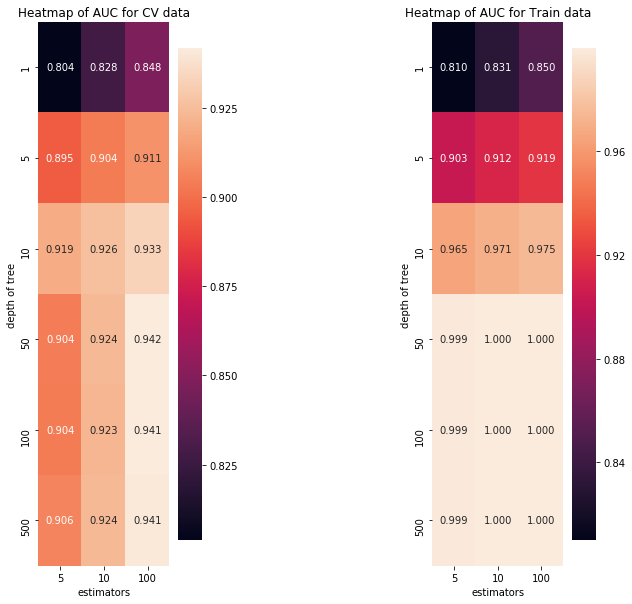

In [49]:
#hyperparameter tunning for Random forest
depth, estimators = clf(avgW2VTrainFE,AmazonReviewDataSampledTrain['Score'],'Random Forest')
print('The optimal depth is %r and number of estimator is %r'%(depth, estimators))
print('='*117)

AUC for Train data is   0.999195051686155 

AUC for the Test data is   0.7839496238537424 



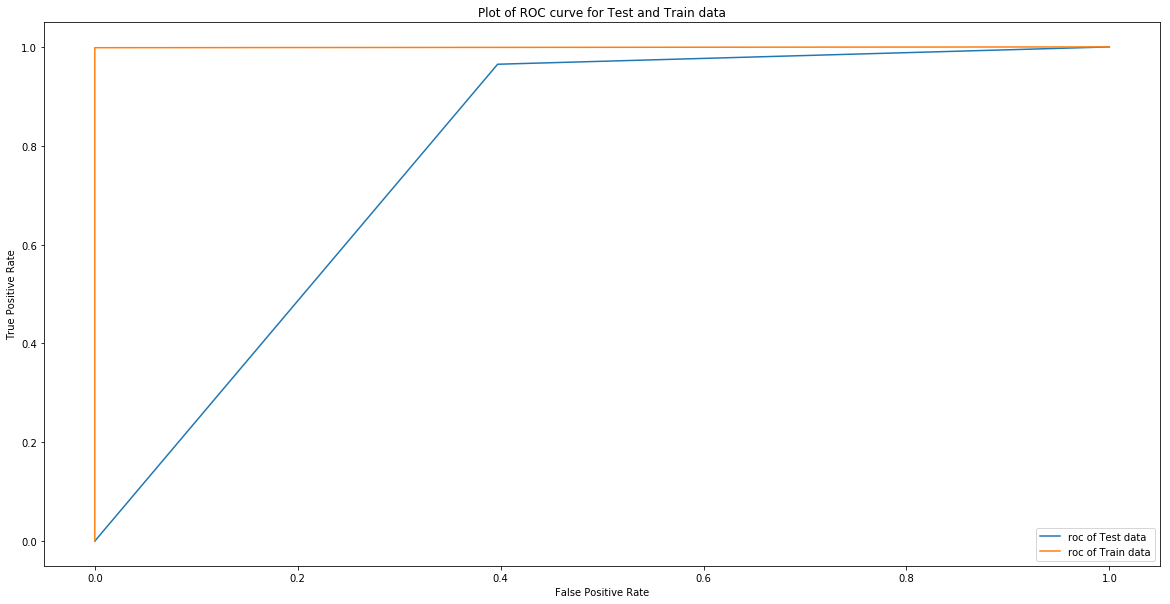

True positive rate = 96.49268485567418
True negative rate = 60.29723991507431


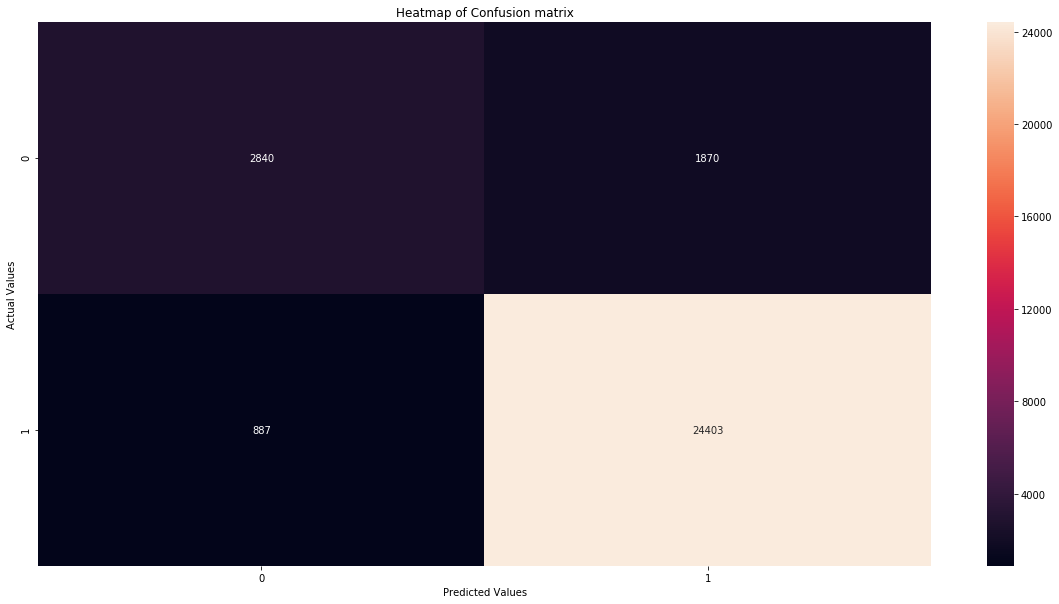

In [50]:
# Random Forest classifier using optimal depth and minimum samples split
auc_test,auc_train,TPR,TNR,coef = clfperformance(avgW2VTrainFE,AmazonReviewDataSampledTrain['Score'],avgW2VTestFE,AmazonReviewDataSampledTest['Score'],estimators,depth,'Random Forest')
table3.add_row(['Avg W2V',depth,estimators,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])

## [6.1.4] Applying Random Forest on TFIDF W2V,<font color='red'> SET 4</font>

In [51]:
#combining the TFIDFW2V of text and summary review
tfidfw2vTrainFE = np.concatenate((tfidfw2vTrain,tfidfw2vTrainSum),axis = 1)
tfidfw2vTestFE = np.concatenate((tfidfw2vTest,tfidfw2vTestSum),axis = 1)

For depth = 1
Number of Estimators = 5 , the auc for train data = 0.78114 and cv data = 0.77986
Number of Estimators = 10 , the auc for train data = 0.79092 and cv data = 0.78799
Number of Estimators = 100 , the auc for train data = 0.81761 and cv data = 0.81504
For depth = 5
Number of Estimators = 5 , the auc for train data = 0.88421 and cv data = 0.87483
Number of Estimators = 10 , the auc for train data = 0.89098 and cv data = 0.88065
Number of Estimators = 100 , the auc for train data = 0.89781 and cv data = 0.88825
For depth = 10
Number of Estimators = 5 , the auc for train data = 0.95712 and cv data = 0.90073
Number of Estimators = 10 , the auc for train data = 0.96372 and cv data = 0.90818
Number of Estimators = 100 , the auc for train data = 0.96953 and cv data = 0.91589
For depth = 50
Number of Estimators = 5 , the auc for train data = 0.99872 and cv data = 0.88611
Number of Estimators = 10 , the auc for train data = 0.99974 and cv data = 0.90489
Number of Estimators = 100 , t

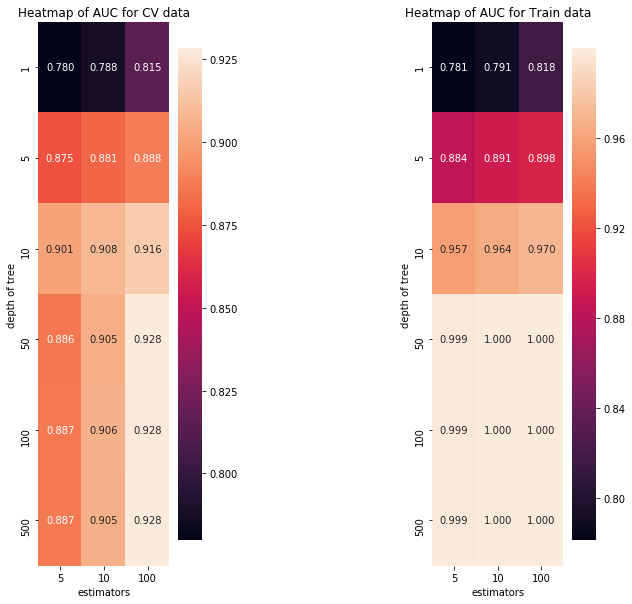

In [52]:
#Hyperparameter tunning for Random forest
depth, estimators = clf(tfidfw2vTrainFE,AmazonReviewDataSampledTrain['Score'],'Random Forest')
print('The optimal depth is %r and number of estimator is %r'%(depth, estimators))
print('='*117)

AUC for Train data is   0.9993645144890697 

AUC for the Test data is   0.7576536381792858 



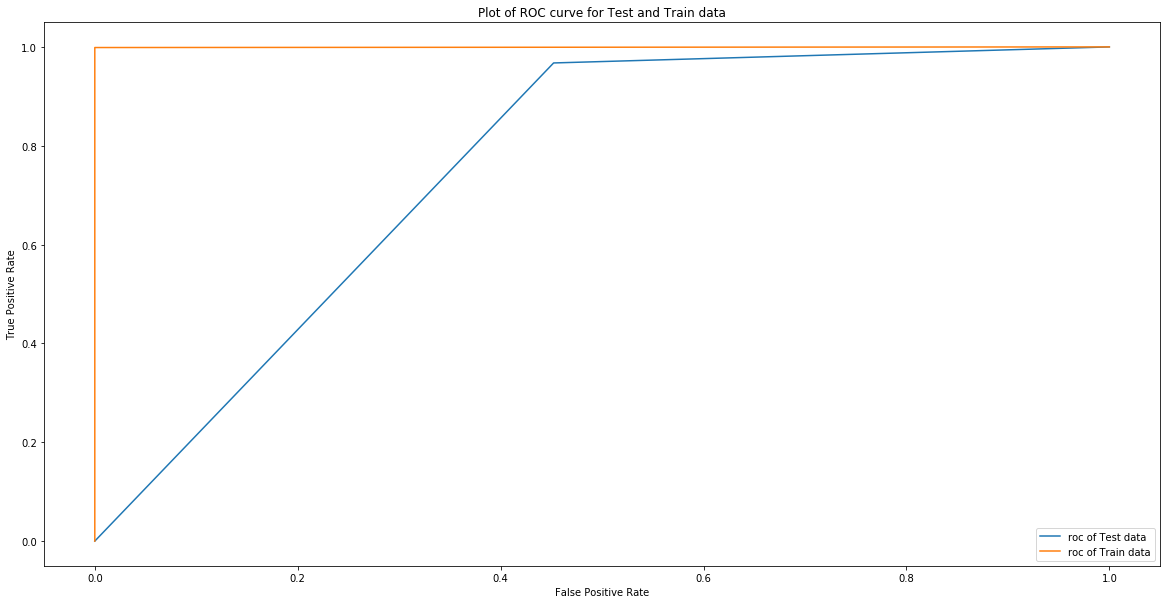

True positive rate = 96.75365757216291
True negative rate = 54.77707006369427


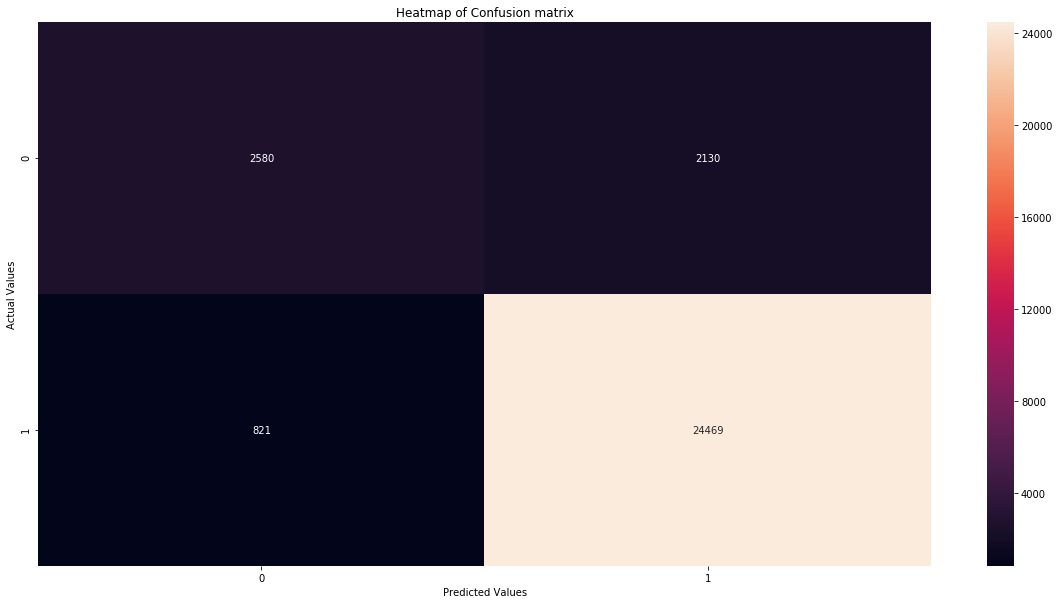

In [53]:
#Random Forest classifier using optimal depth and number of estimators
auc_test,auc_train,TPR,TNR,coef = clfperformance(tfidfw2vTrainFE,AmazonReviewDataSampledTrain['Score'],tfidfw2vTestFE,AmazonReviewDataSampledTest['Score'],estimators,depth,'Random Forest')
table3.add_row(['TFIDF W2V',depth,estimators,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])

# [6.2] XGBOOST

In [36]:
#Pretty table for summarizing the results
table4 = PrettyTable()
table4.field_names = ['Vectorizer','Optimal Depth','Number of Estimators','AUC','TPR','TNR']

## [6.2.1] Applying XgBoost on BOW,<font color='red'> SET 1</font>

In [55]:
#combining the bow for text and summary review
combined_features = FeatureUnion([( 'count_v01', bagofwords),('count_v02',bagofwordsSum)])

bowTrainFE = combined_features.transform(AmazonReviewDataSampledTrain['Text'] + ' ' +AmazonReviewDataSampledTrain['Summary'])
bowTestFE  = combined_features.transform(AmazonReviewDataSampledTest['Text'] + ' '+ AmazonReviewDataSampledTest['Summary'])


For depth = 1
Number of Estimators = 5 , the auc for train data = 0.68819 and cv data = 0.68578
Number of Estimators = 10 , the auc for train data = 0.69313 and cv data = 0.69066
Number of Estimators = 100 , the auc for train data = 0.72954 and cv data = 0.72885
For depth = 5
Number of Estimators = 5 , the auc for train data = 0.80729 and cv data = 0.80281
Number of Estimators = 10 , the auc for train data = 0.80728 and cv data = 0.80283
Number of Estimators = 100 , the auc for train data = 0.82401 and cv data = 0.81902
For depth = 10
Number of Estimators = 5 , the auc for train data = 0.87501 and cv data = 0.856
Number of Estimators = 10 , the auc for train data = 0.87538 and cv data = 0.8564
Number of Estimators = 100 , the auc for train data = 0.87991 and cv data = 0.85953
For depth = 50
Number of Estimators = 5 , the auc for train data = 0.93742 and cv data = 0.87963
Number of Estimators = 10 , the auc for train data = 0.93767 and cv data = 0.87977
Number of Estimators = 100 , the 

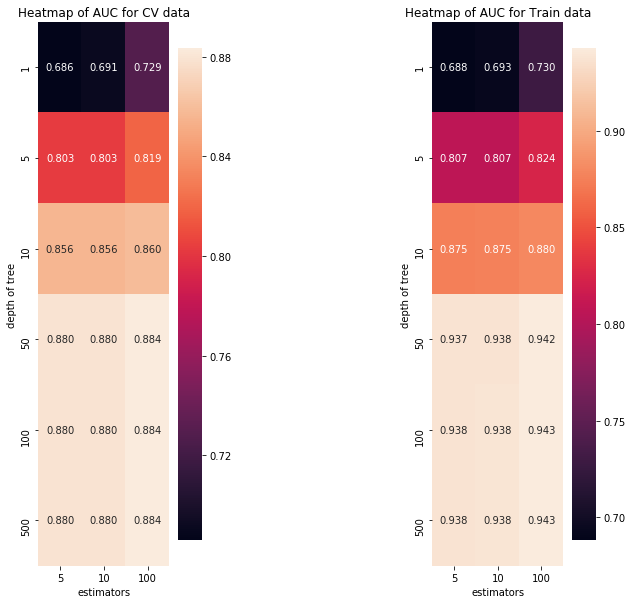

In [56]:
# Xgboost classifier to find the optimal depth and number of estimators
depth, estimators = clf(bowTrainFE,AmazonReviewDataSampledTrain['Score'],'Xgboost')
print('The optimal depth is %r and number of estimator is %r'%(depth, estimators))
print('='*117)


AUC for Train data is   0.6528721246641775 

AUC for the Test data is   0.6324403794959363 



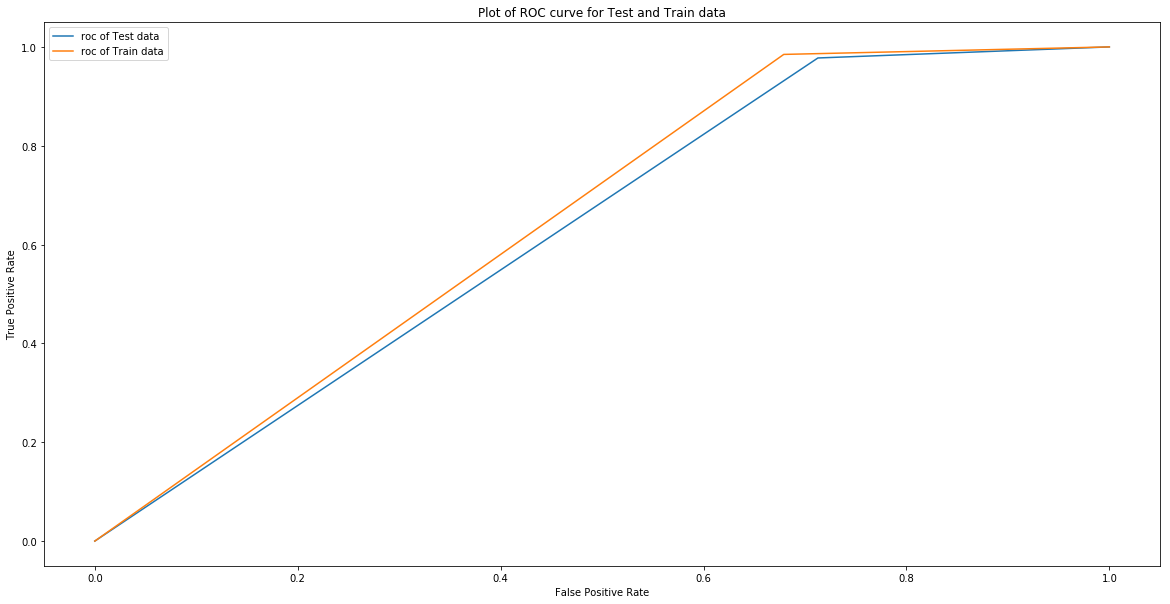

True positive rate = 97.76196124950573
True negative rate = 28.726114649681527


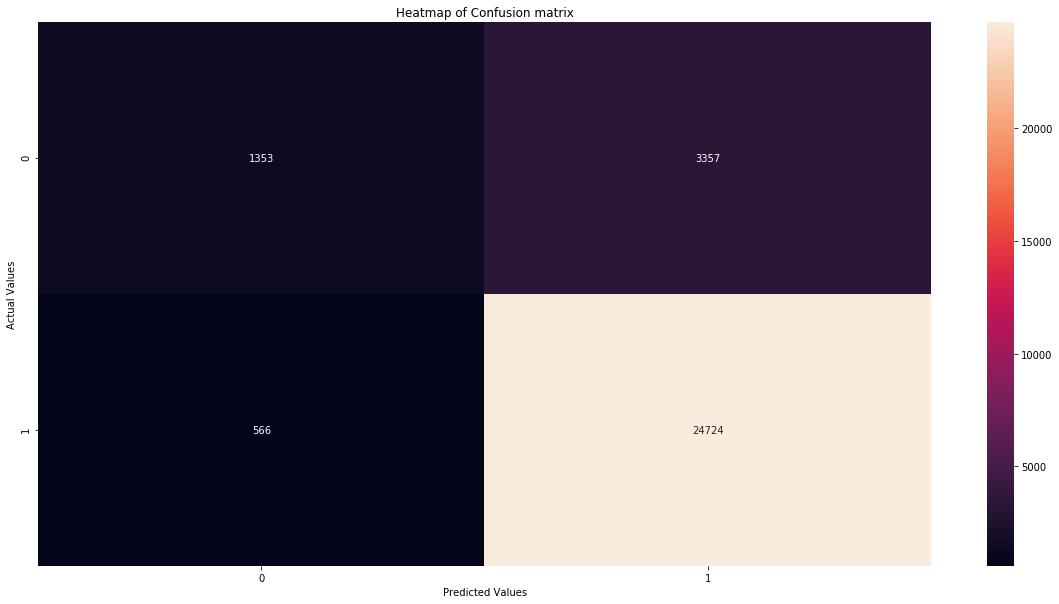

In [57]:
# Xgboost classifier using optimal depth and number of estimators
auc_test,auc_train,TPR,TNR,coef = clfperformance(bowTrain,AmazonReviewDataSampledTrain['Score'],bowTest,AmazonReviewDataSampledTest['Score'],estimators,depth,'Xgboost')
table4.add_row(['Bag of Words',depth,estimators,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])

### [6.2.1] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

20 Most important features in Positive and Negative Class


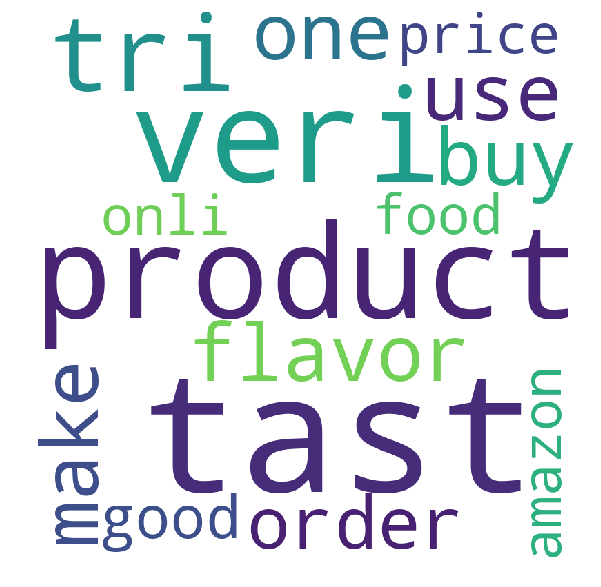

In [58]:
#word cloud for top 20 features
TopFeatures(20,combined_features,coef)

## [6.2.2] Applying XgBoost on TFIDF,<font color='red'> SET 2</font>

In [38]:
# combining the TFIDF of text and summary review
combined_features = FeatureUnion([( 'count_v01', tfidfVec),('count_v02',tfidfVecSum)])

tfidfTrainFE = combined_features.transform(AmazonReviewDataSampledTrain['Text'] + ' ' +AmazonReviewDataSampledTrain['Summary'])
tfidfTestFE  = combined_features.transform(AmazonReviewDataSampledTest['Text'] + ' '+ AmazonReviewDataSampledTest['Summary'])


For depth = 1
Number of Estimators = 5 , the auc for train data = 0.67198 and cv data = 0.67081
Number of Estimators = 10 , the auc for train data = 0.68715 and cv data = 0.68611
Number of Estimators = 100 , the auc for train data = 0.72058 and cv data = 0.71869
For depth = 5
Number of Estimators = 5 , the auc for train data = 0.82168 and cv data = 0.81533
Number of Estimators = 10 , the auc for train data = 0.82226 and cv data = 0.81594
Number of Estimators = 100 , the auc for train data = 0.83242 and cv data = 0.82476
For depth = 10
Number of Estimators = 5 , the auc for train data = 0.88847 and cv data = 0.86489
Number of Estimators = 10 , the auc for train data = 0.88877 and cv data = 0.86516
Number of Estimators = 100 , the auc for train data = 0.89504 and cv data = 0.87043
For depth = 50
Number of Estimators = 5 , the auc for train data = 0.95773 and cv data = 0.89169
Number of Estimators = 10 , the auc for train data = 0.95818 and cv data = 0.89234
Number of Estimators = 100 , t

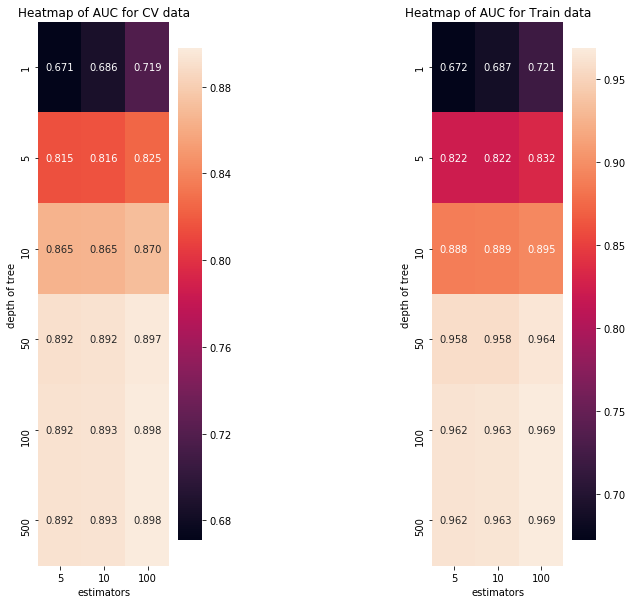

In [39]:
#hyperparameter tunning for Xgboost
depth, estimators = clf(tfidfTrainFE,AmazonReviewDataSampledTrain['Score'],'Xgboost')
print('The optimal depth is %r and number of estimator is %r'%(depth, estimators))
print('='*117)

AUC for Train data is   0.8014436179984608 

AUC for the Test data is   0.7421404699120773 



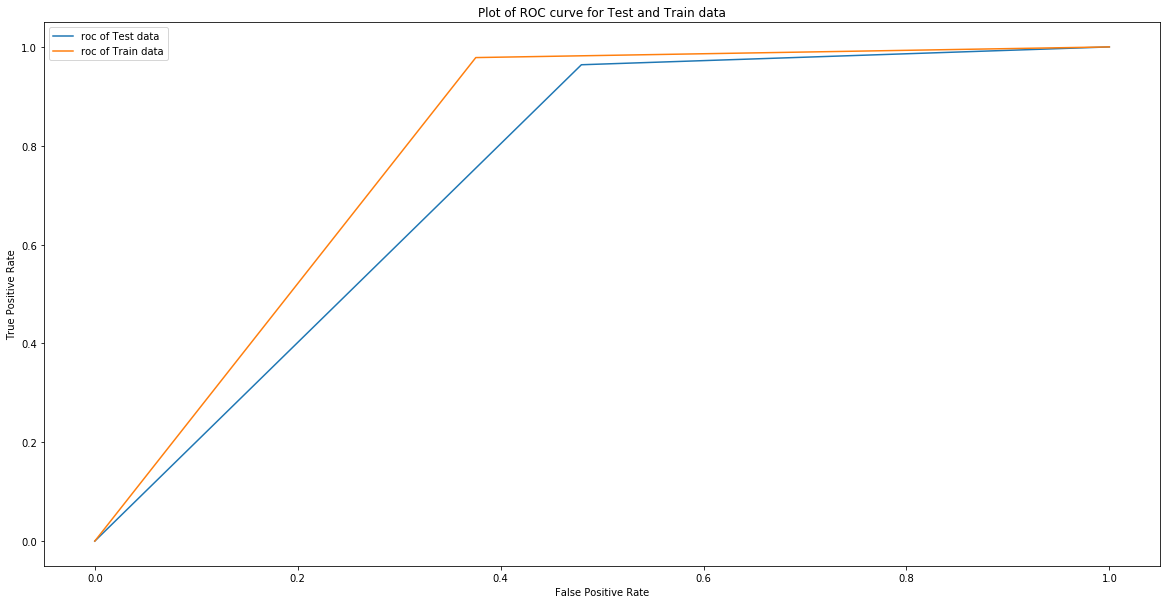

True positive rate = 96.3898774219059
True negative rate = 52.038216560509554


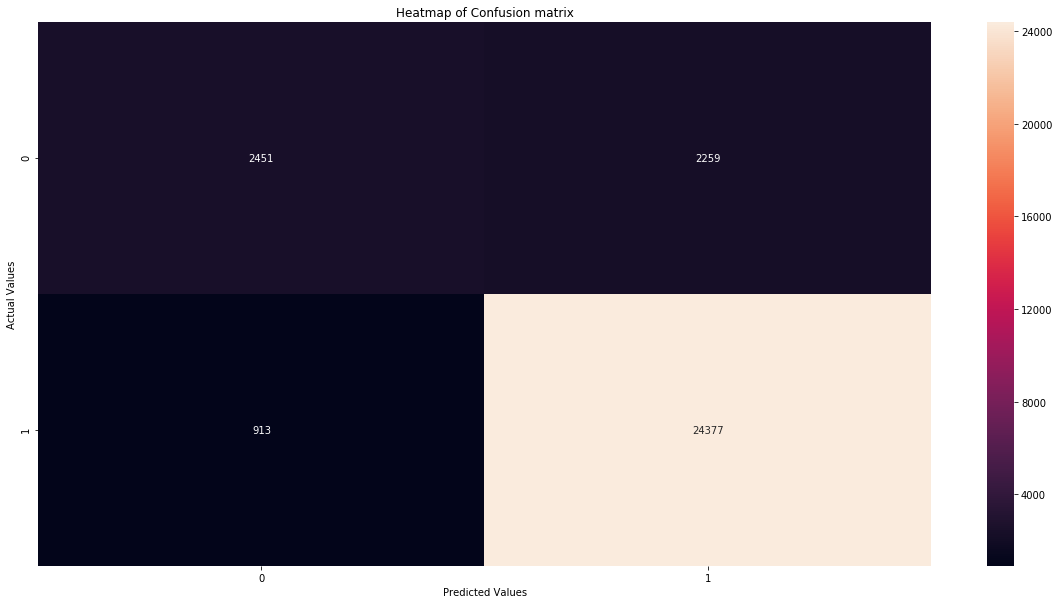

In [40]:
# Xgboost classifier using optimal depth and number of estimators
auc_test,auc_train,TPR,TNR,coef = clfperformance(tfidfTrainFE,AmazonReviewDataSampledTrain['Score'],tfidfTestFE,AmazonReviewDataSampledTest['Score'],estimators,depth,'Xgboost')
table4.add_row(['TFIDF',depth,estimators,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])

### [6.2.2] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

20 Most important features in Positive and Negative Class


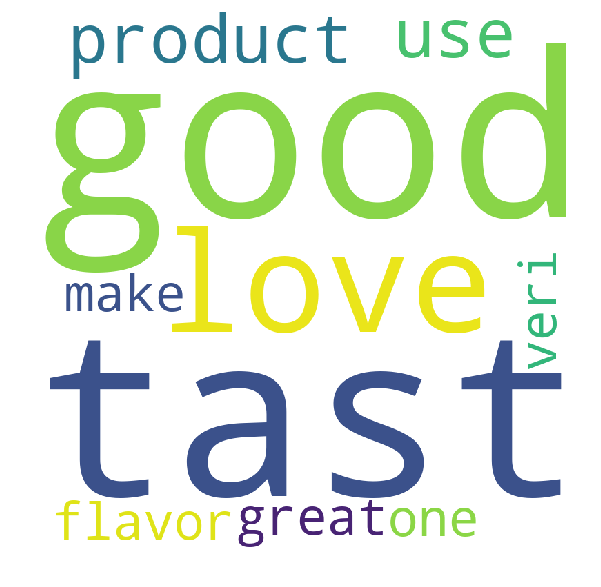

In [41]:
#word cloud of top 20 features 
TopFeatures(20,combined_features,coef)

## [6.2.3] Applying XgBoost on AVG W2V,<font color='red'> SET 3</font>

In [36]:
#Combining the w2v of text and summary 
avgW2VTrainFE = np.concatenate((avgW2VTrain,avgW2VTrainSum),axis = 1)
avgW2VTestFE = np.concatenate((avgW2VTest,avgW2VTestSum),axis = 1)

For depth = 1
Number of Estimators = 5 , the auc for train data = 0.68364 and cv data = 0.68302
Number of Estimators = 10 , the auc for train data = 0.69599 and cv data = 0.69441
Number of Estimators = 100 , the auc for train data = 0.74651 and cv data = 0.74426
For depth = 5
Number of Estimators = 5 , the auc for train data = 0.86727 and cv data = 0.85917
Number of Estimators = 10 , the auc for train data = 0.86834 and cv data = 0.85995
Number of Estimators = 100 , the auc for train data = 0.8786 and cv data = 0.86977
For depth = 10
Number of Estimators = 5 , the auc for train data = 0.94713 and cv data = 0.89552
Number of Estimators = 10 , the auc for train data = 0.94839 and cv data = 0.89668
Number of Estimators = 100 , the auc for train data = 0.95951 and cv data = 0.9078
For depth = 50
Number of Estimators = 5 , the auc for train data = 0.96889 and cv data = 0.89708
Number of Estimators = 10 , the auc for train data = 0.96951 and cv data = 0.89801
Number of Estimators = 100 , the

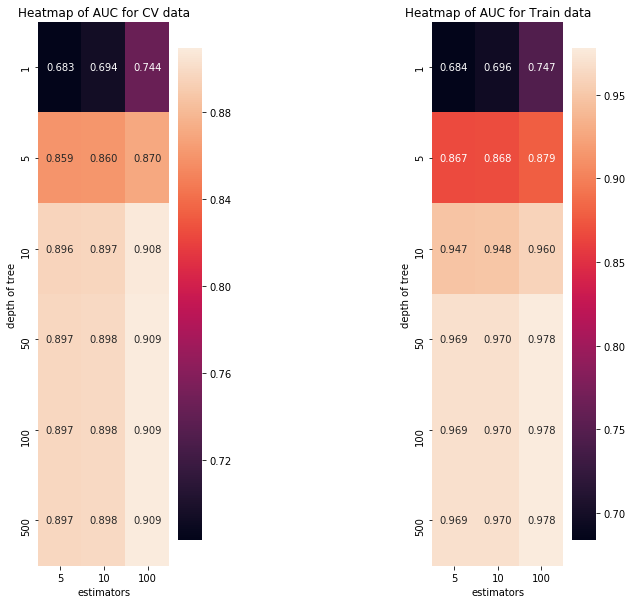

In [41]:
#hyperparameter tunning for Xgboost
depth, estimators = clf(avgW2VTrainFE,AmazonReviewDataSampledTrain['Score'],'Xgboost')
print('The optimal depth is %r and number of estimator is %r'%(depth, estimators))
print('='*117)

AUC for Train data is   0.9992258140420981 

AUC for the Test data is   0.7803776825763815 



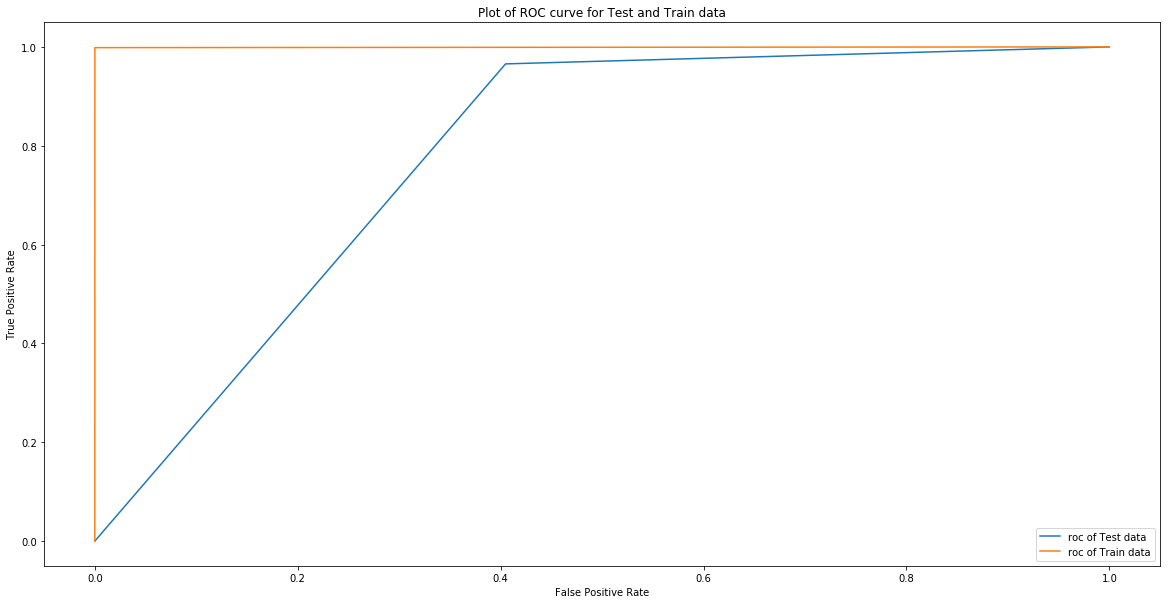

True positive rate = 96.56385923289838
True negative rate = 59.51167728237792


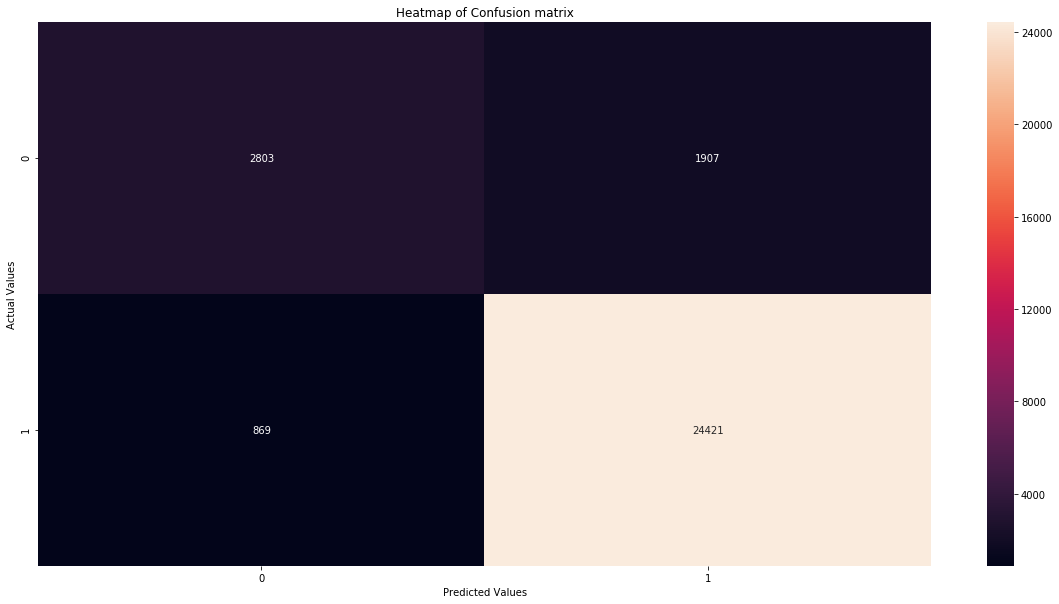

In [44]:
# Xgboost classifier using optimal depth and number of estimators
auc_test,auc_train,TPR,TNR,coef = clfperformance(avgW2VTrainFE,AmazonReviewDataSampledTrain['Score'],avgW2VTestFE,AmazonReviewDataSampledTest['Score'],estimators,depth,'Random Forest')
table4.add_row(['Avg W2V',depth,estimators,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])

## [6.2.4] Applying XgBoost on TFIDF W2V,<font color='red'> SET 4</font>

In [37]:
#combining the TFIDFW2V of text and summary review
tfidfw2vTrainFE = np.concatenate((tfidfw2vTrain,tfidfw2vTrainSum),axis = 1)
tfidfw2vTestFE = np.concatenate((tfidfw2vTest,tfidfw2vTestSum),axis = 1)

For depth = 1
Number of Estimators = 5 , the auc for train data = 0.65029 and cv data = 0.64991
Number of Estimators = 10 , the auc for train data = 0.65052 and cv data = 0.64998
Number of Estimators = 100 , the auc for train data = 0.65635 and cv data = 0.65581
For depth = 5
Number of Estimators = 5 , the auc for train data = 0.84469 and cv data = 0.83337
Number of Estimators = 10 , the auc for train data = 0.8463 and cv data = 0.83465
Number of Estimators = 100 , the auc for train data = 0.85499 and cv data = 0.84307
For depth = 10
Number of Estimators = 5 , the auc for train data = 0.93936 and cv data = 0.87504
Number of Estimators = 10 , the auc for train data = 0.941 and cv data = 0.87647
Number of Estimators = 100 , the auc for train data = 0.95372 and cv data = 0.8893
For depth = 50
Number of Estimators = 5 , the auc for train data = 0.96672 and cv data = 0.87624
Number of Estimators = 10 , the auc for train data = 0.96792 and cv data = 0.87774
Number of Estimators = 100 , the a

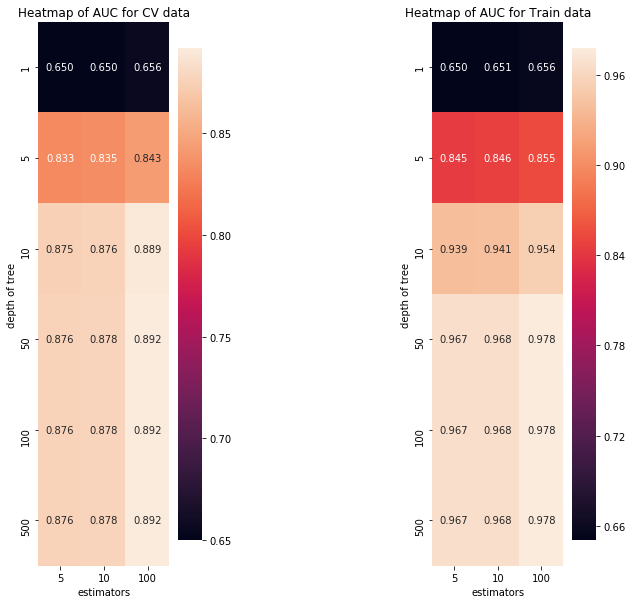

In [40]:
#hyperparameter tunning for Xgboost
depth, estimators = clf(tfidfw2vTrainFE,AmazonReviewDataSampledTrain['Score'],'Xgboost')
print('The optimal depth is %r and number of estimator is %r'%(depth, estimators))
print('='*117)

AUC for Train data is   0.7779429590364151 

AUC for the Test data is   0.6944042734849001 



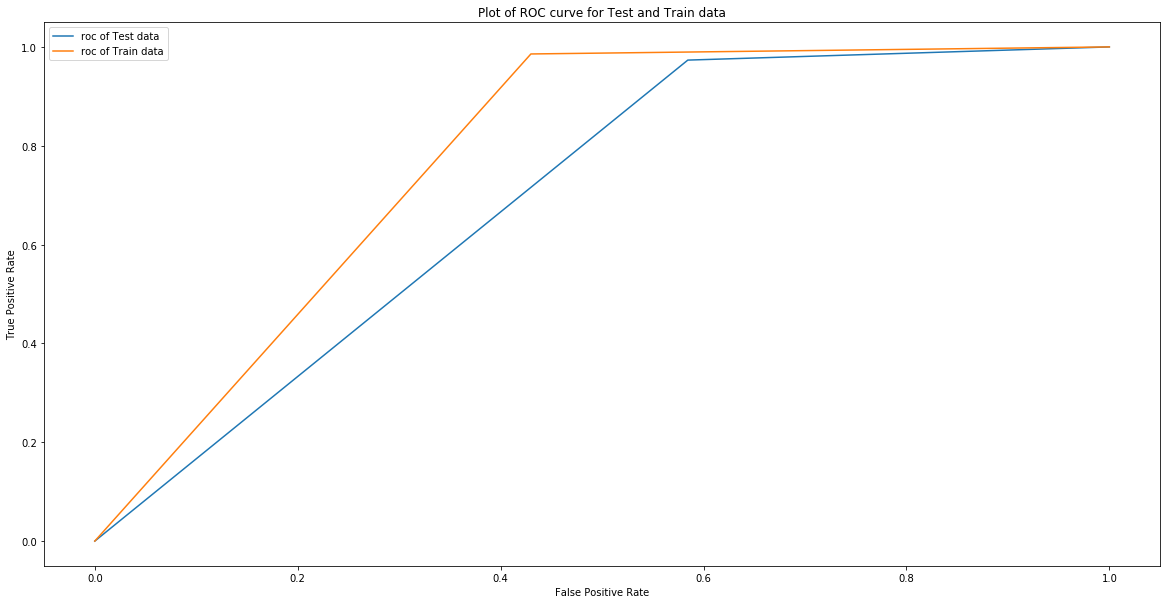

True positive rate = 97.33096085409252
True negative rate = 41.54989384288748


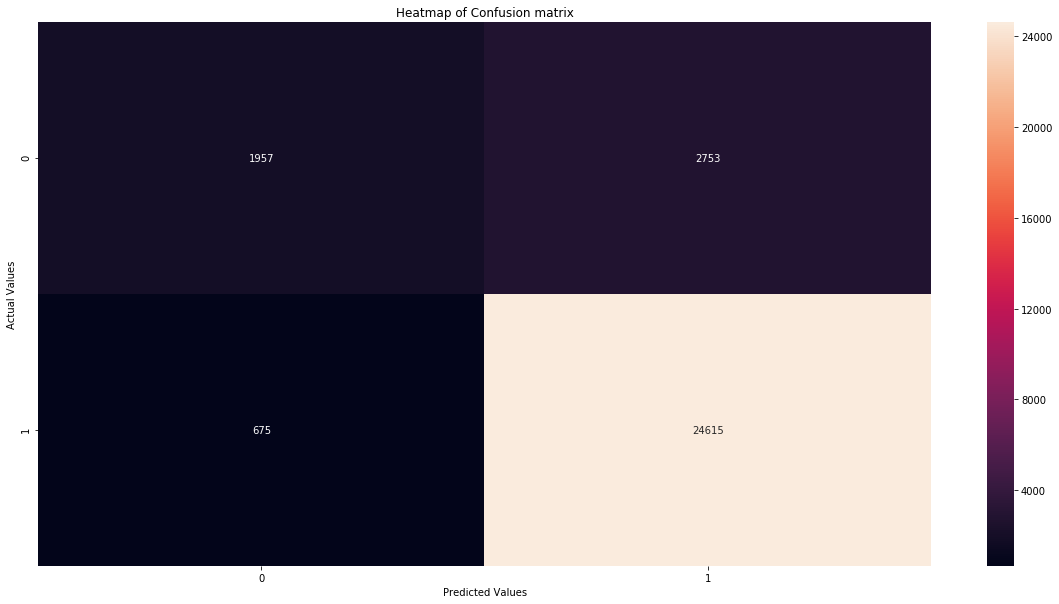

In [41]:
# Xgboost classifier using optimal depth and number of estimators
auc_test,auc_train,TPR,TNR,coef = clfperformance(tfidfw2vTrainFE,AmazonReviewDataSampledTrain['Score'],tfidfw2vTestFE,AmazonReviewDataSampledTest['Score'],estimators,depth,'Xgboost')
table4.add_row(['TFIDF W2V',depth,estimators,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])

# [7] Conclusions

# Summary of results for Text review

In [43]:
#Pretty table for summarizing the results
table1 = PrettyTable()
table1.field_names = ['Vectorizer','Optimal Depth','Number of Estimators','AUC','TPR','TNR']
print("\tTable showing the AUC for different Vectorizer using Random Forest model")
table1.add_row(['Bag of Words',500,100,0.7783,97.2479,58.4288])
table1.add_row(['TFIDF',500,100,0.8069,97.1451,64.2462])
table1.add_row(['Avg W2V',500,100,0.6698,95.9786,37.9830])
table1.add_row(['TFIDF W2V',50,100,0.6305,96.5005,29.6178])
print(table1)

	Table showing the AUC for different Vectorizer using Random Forest model
+--------------+---------------+----------------------+--------+---------+---------+
|  Vectorizer  | Optimal Depth | Number of Estimators |  AUC   |   TPR   |   TNR   |
+--------------+---------------+----------------------+--------+---------+---------+
| Bag of Words |      500      |         100          | 0.7783 | 97.2479 | 58.4288 |
|    TFIDF     |      500      |         100          | 0.8069 | 97.1451 | 64.2462 |
|   Avg W2V    |      500      |         100          | 0.6698 | 95.9786 |  37.983 |
|  TFIDF W2V   |       50      |         100          | 0.6305 | 96.5005 | 29.6178 |
+--------------+---------------+----------------------+--------+---------+---------+


### Observations: 
For Random Forest using Test review, TFIDF performs better as compared to other vectorizer. 
Peformance of all the vectorizer can be improved further by doing Feature Engineering.

In [44]:
#Pretty table for summarizing the results
table2 = PrettyTable()
table2.field_names = ['Vectorizer','Optimal Depth','Number of Estimators','AUC','TPR','TNR']
print("\tTable showing the AUC for different Vectorizer using XgBoost model")
table2.add_row(['Bag of Words',50,100,0.6324,97.762,28.726])
table2.add_row(['TFIDF',500,100,0.665,97.6 ,35.393])
table2.add_row(['Avg W2V',10,100,0.6237,97.398,27.346])
table2.add_row(['TFIDF W2V',10,100,0.559,98.873,12.93])
print(table2)

	Table showing the AUC for different Vectorizer using XgBoost model
+--------------+---------------+----------------------+--------+--------+--------+
|  Vectorizer  | Optimal Depth | Number of Estimators |  AUC   |  TPR   |  TNR   |
+--------------+---------------+----------------------+--------+--------+--------+
| Bag of Words |       50      |         100          | 0.6324 | 97.762 | 28.726 |
|    TFIDF     |      500      |         100          | 0.665  |  97.6  | 35.393 |
|   Avg W2V    |       10      |         100          | 0.6237 | 97.398 | 27.346 |
|  TFIDF W2V   |       10      |         100          | 0.559  | 98.873 | 12.93  |
+--------------+---------------+----------------------+--------+--------+--------+


### Observation: 
For Xgboost classifier, the performance of TFIDF vectorizer is better as comnapred to other vectorizers. 
Performance can be improvesd further by doing feature engineering.

# Summary of Results for Random Forest and Xgboost Classifier usin gfeature engineering. Text and Summary of review is used.

In [45]:
#Pretty table for summarizing the results
table3 = PrettyTable()
table3.field_names = ['Vectorizer','Optimal Depth','Number of Estimators','AUC','TPR','TNR']
print("\tTable showing the AUC for different Vectorizer using Feature Engineering for Random Forest model ")
table3.add_row(['Bag of Words',500,100,0.7797,97.0660,58.8747])
table3.add_row(['TFIDF',500,100,0.8421,97.3072,71.1252])
table3.add_row(['Avg W2V',50,100,0.7839,96.4926,60.2972])
table3.add_row(['TFIDF W2V',500,100,0.756,96.7536,54.7770])
print(table3)

	Table showing the AUC for different Vectorizer using Feature Engineering for Random Forest model 
+--------------+---------------+----------------------+--------+---------+---------+
|  Vectorizer  | Optimal Depth | Number of Estimators |  AUC   |   TPR   |   TNR   |
+--------------+---------------+----------------------+--------+---------+---------+
| Bag of Words |      500      |         100          | 0.7797 |  97.066 | 58.8747 |
|    TFIDF     |      500      |         100          | 0.8421 | 97.3072 | 71.1252 |
|   Avg W2V    |       50      |         100          | 0.7839 | 96.4926 | 60.2972 |
|  TFIDF W2V   |      500      |         100          | 0.756  | 96.7536 |  54.777 |
+--------------+---------------+----------------------+--------+---------+---------+


### Observation:
It can be observed that the TNR of all the vectorizer for Random Forest is improved by combining Text and Summary of the review. The TNR of TFIDF vectorizer is now 71% as compared to 64% in previous case. Again TFIDF vectorizer performs well comapred to other vectorizers.

In [47]:
#Pretty table for summarizing the results
table4 = PrettyTable()
table4.field_names = ['Vectorizer','Optimal Depth','Number of Estimators','AUC','TPR','TNR']
print("\tTable showing the AUC for different Vectorizer using Feature Engineering for XgBoost model")
table4.add_row(['Bag of Words',50,100,0.6324,97.7619,28.7261])
table4.add_row(['TFIDF',100,100,0.7421,96.3898,52.0382])
table4.add_row(['Avg W2V',50,100,0.7803,96.5638,59.5116])
table4.add_row(['TFIDF W2V',50,100,0.6944,97.3309,41.5498])
print(table4)

	Table showing the AUC for different Vectorizer using Feature Engineering for XgBoost model
+--------------+---------------+----------------------+--------+---------+---------+
|  Vectorizer  | Optimal Depth | Number of Estimators |  AUC   |   TPR   |   TNR   |
+--------------+---------------+----------------------+--------+---------+---------+
| Bag of Words |       50      |         100          | 0.6324 | 97.7619 | 28.7261 |
|    TFIDF     |      100      |         100          | 0.7421 | 96.3898 | 52.0382 |
|   Avg W2V    |       50      |         100          | 0.7803 | 96.5638 | 59.5116 |
|  TFIDF W2V   |       50      |         100          | 0.6944 | 97.3309 | 41.5498 |
+--------------+---------------+----------------------+--------+---------+---------+


 ### Observation: It can be observed that the TNR of all the vectorizer for Random Forest is improved by combining Text and Summary of the review. TFIDF performs better as compared to other vectorizers

## Final Conclusion:

Performance of Random Forest and Xgboost can be improved further by carefully tunning the hyperparameters and doing more feature engineering.   
TFIDF performs better as compared to other vectorizers.

# END